# House Price prediction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as mso
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder,scale
from sklearn.feature_selection import RFE

#### Load the dataset

In [2]:
master_data = pd.read_csv('train.csv', keep_default_na= False, na_values=['', '-1.#IND', '-1.#QNAN', '-NaN', '-nan',
                                                                          '1.#IND', '1.#QNAN', 'NULL', 'NaN', 'nan', 'null'])

In [3]:
print(master_data.info())
master_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Id             1460 non-null   int64 
 1   MSSubClass     1460 non-null   int64 
 2   MSZoning       1460 non-null   object
 3   LotFrontage    1460 non-null   object
 4   LotArea        1460 non-null   int64 
 5   Street         1460 non-null   object
 6   Alley          1460 non-null   object
 7   LotShape       1460 non-null   object
 8   LandContour    1460 non-null   object
 9   Utilities      1460 non-null   object
 10  LotConfig      1460 non-null   object
 11  LandSlope      1460 non-null   object
 12  Neighborhood   1460 non-null   object
 13  Condition1     1460 non-null   object
 14  Condition2     1460 non-null   object
 15  BldgType       1460 non-null   object
 16  HouseStyle     1460 non-null   object
 17  OverallQual    1460 non-null   int64 
 18  OverallCond    1460 non-null

Id  MSSubClass MSZoning LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL          65     8450   Pave    NA      Reg   
1   2          20       RL          80     9600   Pave    NA      Reg   
2   3          60       RL          68    11250   Pave    NA      IR1   
3   4          70       RL          60     9550   Pave    NA      IR1   
4   5          60       RL          84    14260   Pave    NA      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0     NA    NA          NA       0      2   
1         Lvl    AllPub  ...        0     NA    NA          NA       0      5   
2         Lvl    AllPub  ...        0     NA    NA          NA       0      9   
3         Lvl    AllPub  ...        0     NA    NA          NA       0      2   
4         Lvl    AllPub  ...        0     NA    NA          NA       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

Verify if all coninuous variables are correctly recorded by checking datatype of variables.

In [4]:
# drop column id as it does not contribute anyway
master_data.drop('Id', axis = 1, inplace = True)

- LotFrontage and MasVnrArea are continuous variable, hence can't be of object type. Chcek the contents of these coulmns.
- LotFrontage has to be converted to numeric
- compare MasVnrArea with MasVnrType. If MasVnrType is 'None' then MasVnrArea can be treated as 0.

In [5]:
master_data['LotFrontage'] = pd.to_numeric(master_data['LotFrontage'], errors ='coerce')

In [6]:
print((master_data.MasVnrArea == 'NA').sum())
print(master_data.MasVnrType.value_counts())
master_data.loc[master_data.MasVnrArea == 'NA', ['MasVnrArea','MasVnrType']]

8
None       864
BrkFace    445
Stone      128
BrkCmn      15
NA           8
Name: MasVnrType, dtype: int64


MasVnrArea MasVnrType
234          NA         NA
529          NA         NA
650          NA         NA
936          NA         NA
973          NA         NA
977          NA         NA
1243         NA         NA
1278         NA         NA

NA does not have any meaning for MasVnrType as per datadictionary. So let's treat it as missing data. Hence the NA entries in MasVnrArea should also be treated as missing data.

In [7]:
master_data['MasVnrArea'] = pd.to_numeric(master_data['MasVnrArea'], errors ='coerce')
master_data.MasVnrArea.isnull().sum()

8

'NA' is not a valid category for certain categorical variables. It has to be treated as missing value in those columns.
To identify such columns, check the possible values for each categorical variable

In [8]:
sub_data = master_data.copy()
for item in master_data.select_dtypes(include = 'object').columns:
    print('-----------------'+item+'--------------------------')
    sub_data[item] = sub_data[item].str.upper()
    print(sub_data[item].value_counts(ascending = False))

-----------------MSZoning--------------------------
RL         1151
RM          218
FV           65
RH           16
C (ALL)      10
Name: MSZoning, dtype: int64
-----------------Street--------------------------
PAVE    1454
GRVL       6
Name: Street, dtype: int64
-----------------Alley--------------------------
NA      1369
GRVL      50
PAVE      41
Name: Alley, dtype: int64
-----------------LotShape--------------------------
REG    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64
-----------------LandContour--------------------------
LVL    1311
BNK      63
HLS      50
LOW      36
Name: LandContour, dtype: int64
-----------------Utilities--------------------------
ALLPUB    1459
NOSEWA       1
Name: Utilities, dtype: int64
-----------------LotConfig--------------------------
INSIDE     1052
CORNER      263
CULDSAC      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64
-----------------LandSlope--------------------------
GTL    1382
MOD      65
SEV      

Check the applicability of 'NA' for each variable. Also, check the correctness of various values of it. Found the following discrepancies:
1. BldgType: TWNHS -> TWNHSI or TWNHSE
2. Exterior2nd: BRK CMN - > BrkComm
3. MasVnrType: NA -> NaN
4. Electrical: NA -> NaN
5. GarageYrBlt: NA - > 0

In [9]:
print(len(sub_data[sub_data['GarageYrBlt'] == 'NA']))
((sub_data['GarageYrBlt'] == 'NA') & (sub_data['GarageType'] == 'NA')).sum()

81


81

GarageYrBlt is having missing values for those records where there aren't any Garage. Hence we can keep them as NA for now.


In [10]:
# Since MasVnrType and Electrical do not ahve categoey as 'NA', treat those cases as missing values
sub_data[['MasVnrType','Electrical']] = sub_data[['MasVnrType','Electrical']].replace({'NA':np.nan})

In [11]:
# recheck the categories
print(sub_data.MasVnrType.value_counts())
print(sub_data.Electrical.value_counts())
print(sub_data.GarageYrBlt.value_counts())

NONE       864
BRKFACE    445
STONE      128
BRKCMN      15
Name: MasVnrType, dtype: int64
SBRKR    1334
FUSEA      94
FUSEF      27
FUSEP       3
MIX         1
Name: Electrical, dtype: int64
NA      81
2005    65
2006    59
2004    53
2003    50
        ..
1906     1
1927     1
1908     1
1933     1
1900     1
Name: GarageYrBlt, Length: 98, dtype: int64


In [12]:
# perform data correction for Exterior2nd
sub_data['Exterior2nd'] = sub_data.Exterior2nd.replace('BRK CMN', 'BRKCOMM')
sub_data.BldgType.value_counts()

1FAM      1220
TWNHSE     114
DUPLEX      52
TWNHS       43
2FMCON      31
Name: BldgType, dtype: int64

- perform data correction for BldgType, assuming TWNHS as TWNHSI

In [13]:
sub_data['BldgType'] = sub_data.BldgType.replace('TWNHS', 'TWNHSI')
sub_data.BldgType.value_counts()

1FAM      1220
TWNHSE     114
DUPLEX      52
TWNHSI      43
2FMCON      31
Name: BldgType, dtype: int64

In [14]:
# recheck the amount of missing values
sub_data.isnull().sum().sort_values(ascending = False)[:5]

LotFrontage    259
MasVnrType       8
MasVnrArea       8
Electrical       1
SalePrice        0
dtype: int64

For the above variables with missing values, there aren't any business logic with which we can impute the null cases. So let's keep them as it is for now. We can treat these after the train test split.

In [15]:
# extract continuous and categorical variables in the dataset
category_vars = sub_data.select_dtypes(include = 'object').columns
cont_vars = sub_data.select_dtypes(exclude = 'object').columns
print(len(category_vars), len(cont_vars))
print(category_vars)
cont_vars

44 36
Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
       'Fence', 'MiscFeature', 'SaleType', 'SaleCondition'],
      dtype='object')


Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

#### EDA: Univariate and bivariate analysis

In [16]:
print(sub_data.BsmtFullBath.value_counts())
print(sub_data.BsmtHalfBath.value_counts())
print(sub_data.FullBath.value_counts())
print(sub_data.BedroomAbvGr.value_counts())
print(sub_data.GarageCars.value_counts())

0    856
1    588
2     15
3      1
Name: BsmtFullBath, dtype: int64
0    1378
1      80
2       2
Name: BsmtHalfBath, dtype: int64
2    768
1    650
3     33
0      9
Name: FullBath, dtype: int64
3    804
2    358
4    213
1     50
5     21
6      7
0      6
8      1
Name: BedroomAbvGr, dtype: int64
2    824
1    369
3    181
0     81
4      5
Name: GarageCars, dtype: int64


In [17]:
# prepare a list of ordered categorical parameters
category_vars = list(category_vars)
cont_vars = list(cont_vars)
category_vars.append('MSSubClass')
category_vars.append('MoSold')
cont_vars.remove('MSSubClass')
cont_vars.remove('MoSold')
ord_cate_vars = ['OverallQual', 'OverallCond', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath','BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars']
for item in ord_cate_vars:
    cont_vars.remove(item)
cont_vars

['LotFrontage',
 'LotArea',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'YrSold',
 'SalePrice']

<ipython-input-18-f7f40c94d3e3>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize = (10,5))


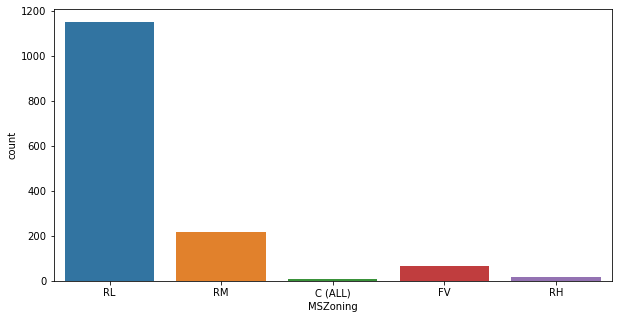

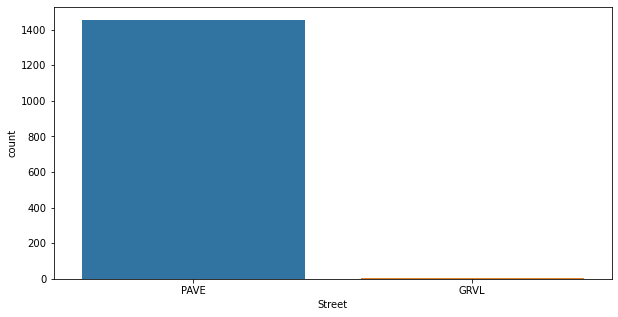

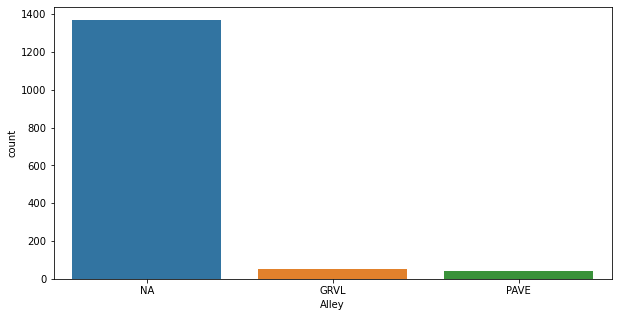

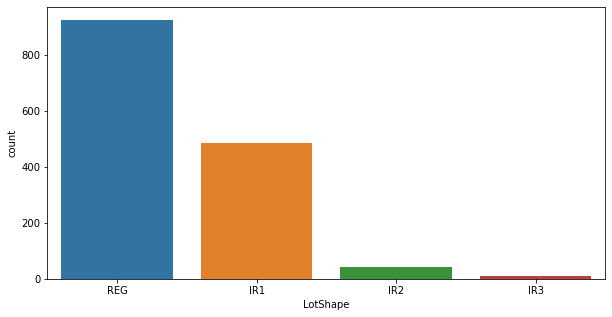

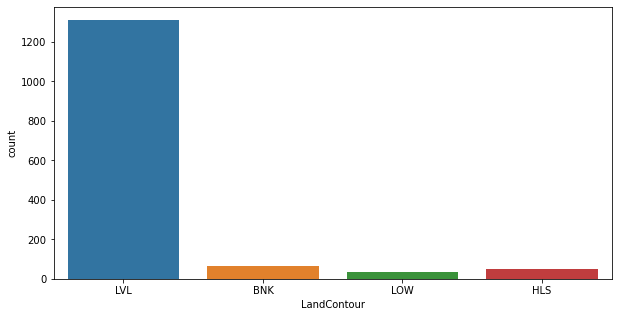

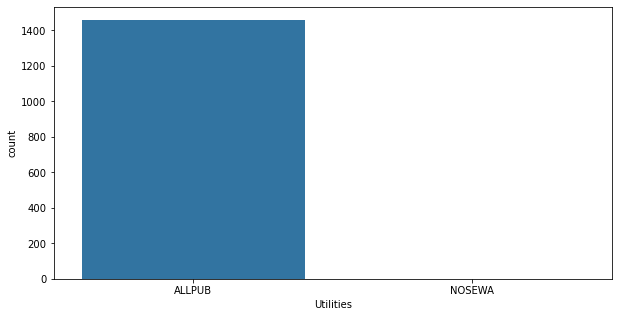

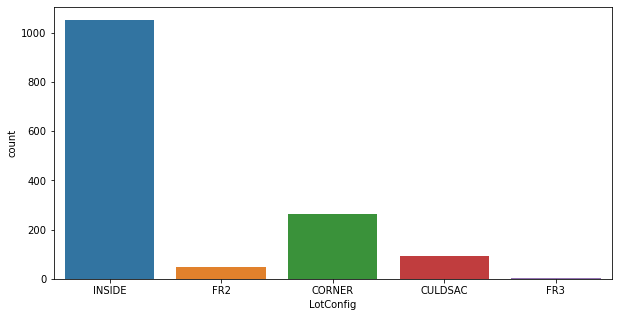

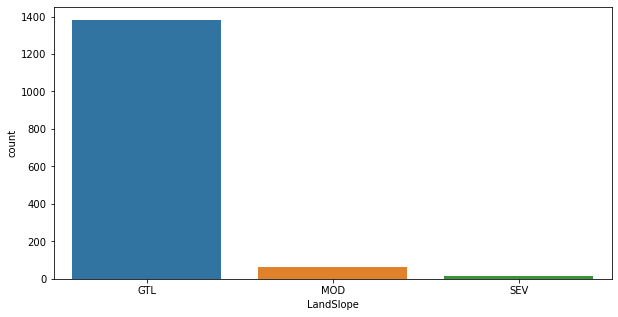

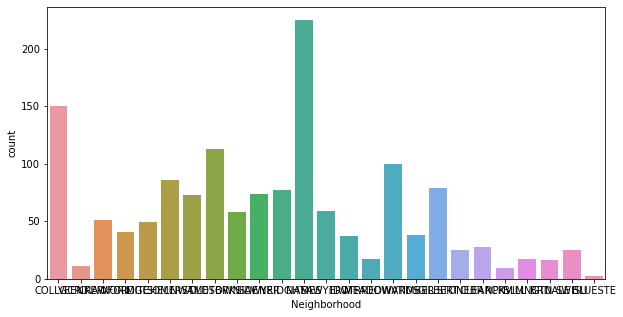

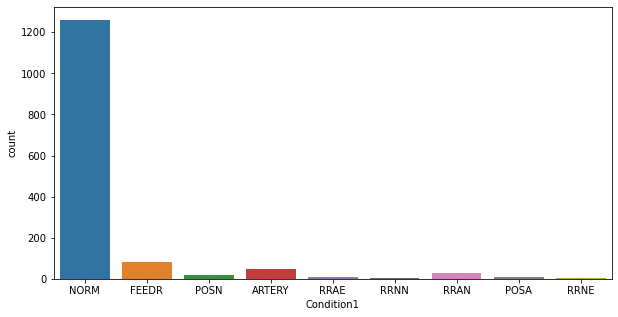

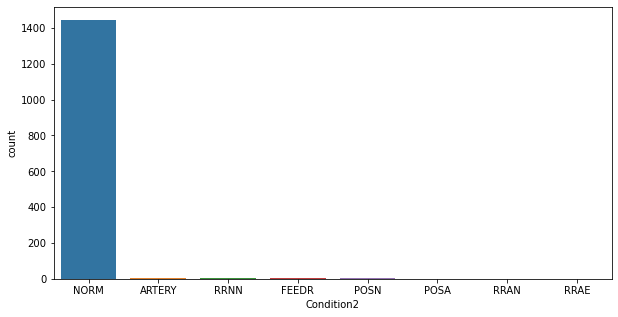

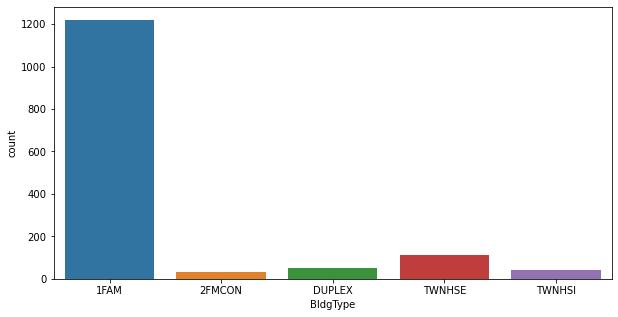

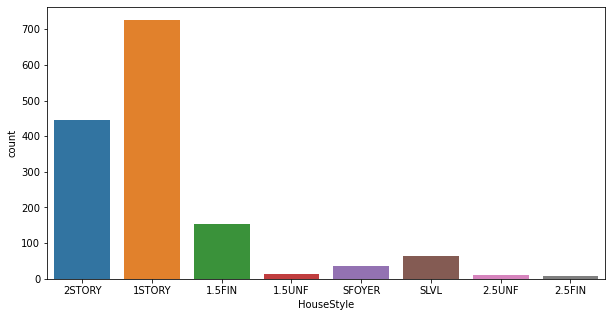

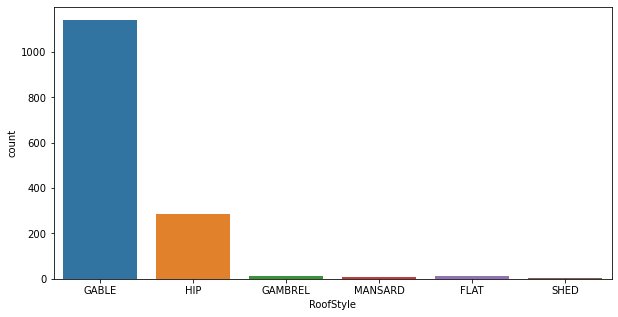

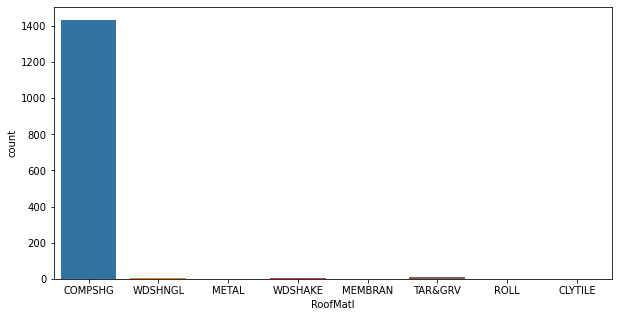

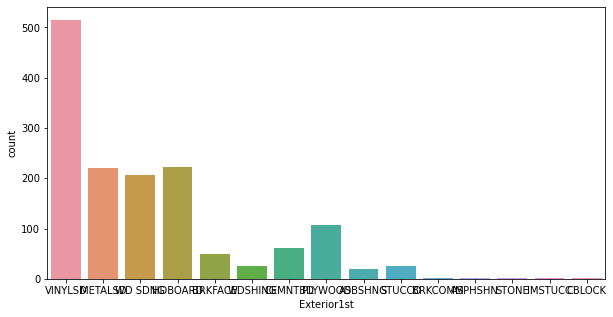

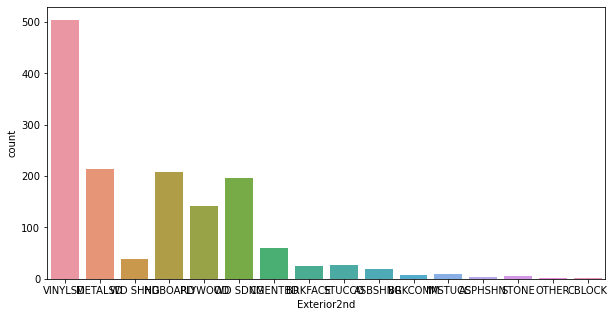

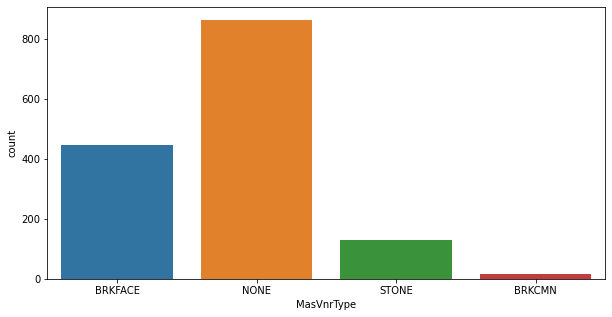

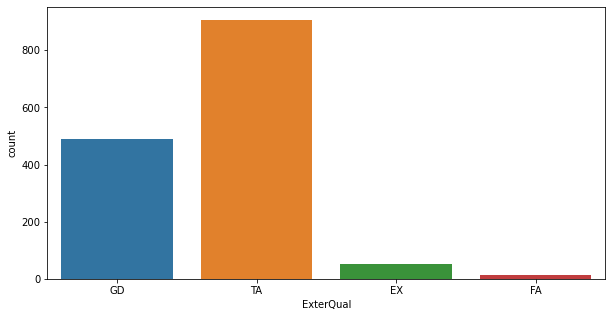

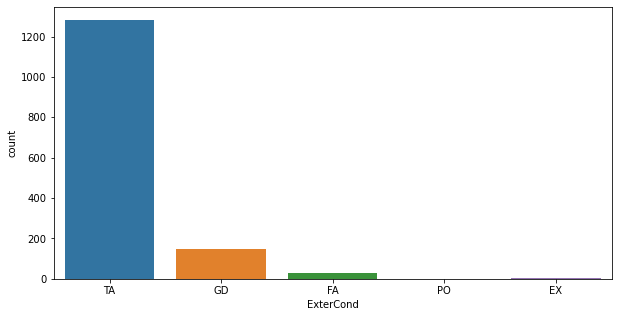

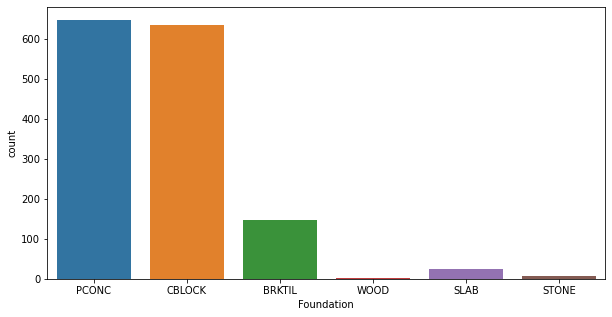

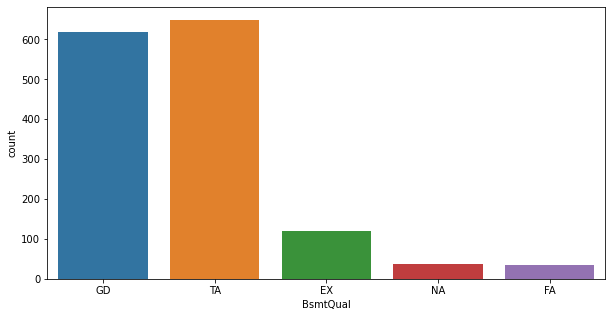

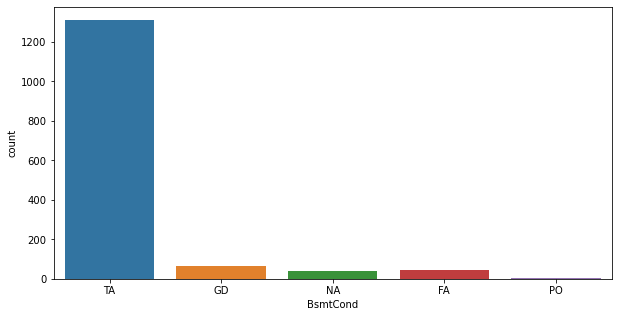

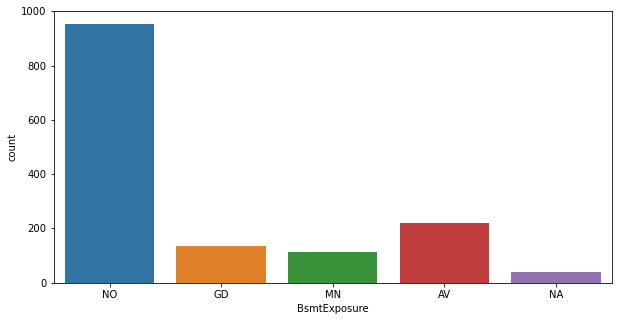

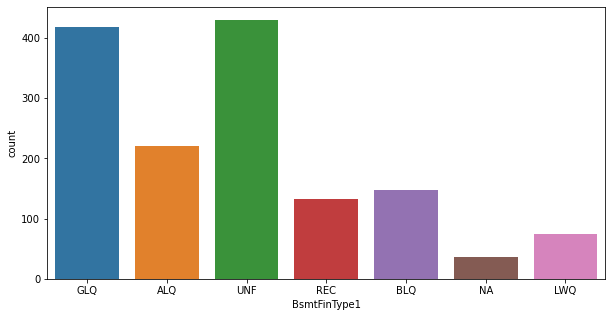

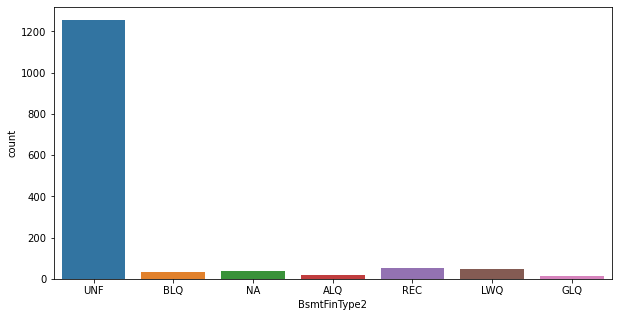

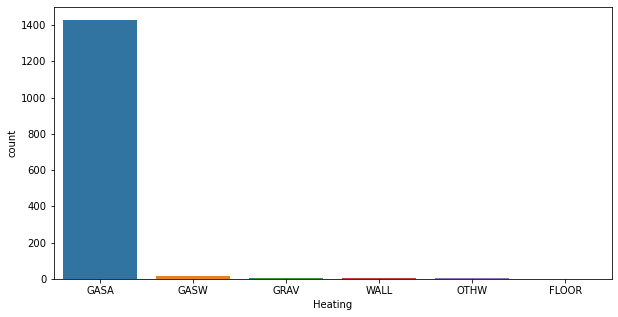

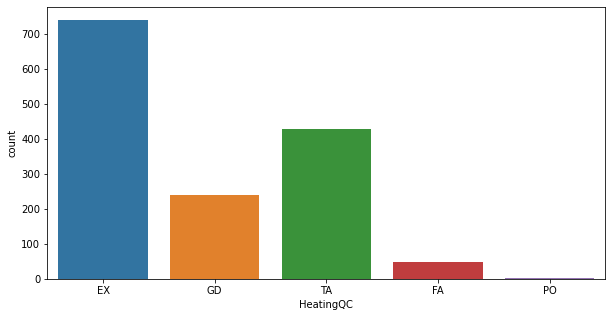

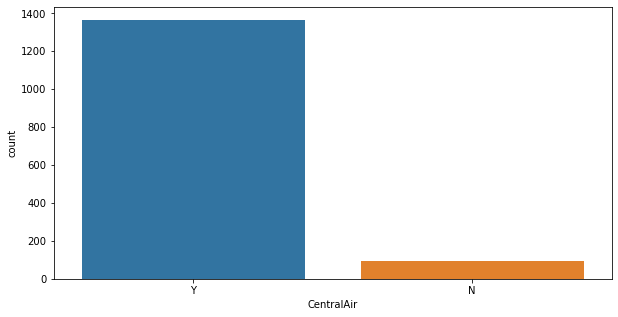

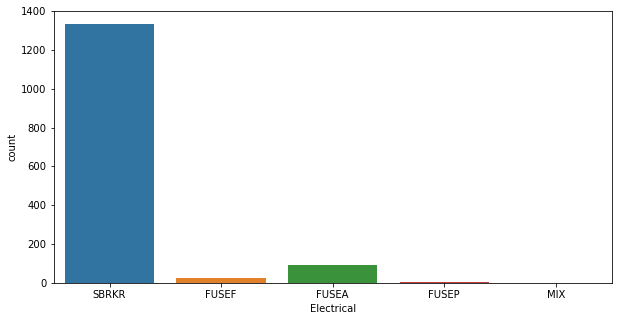

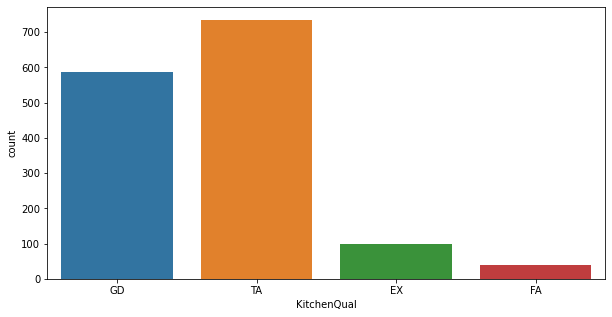

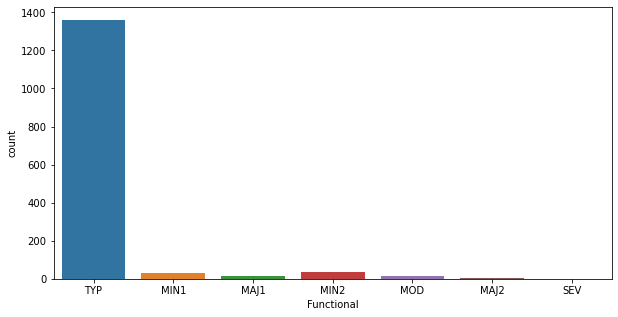

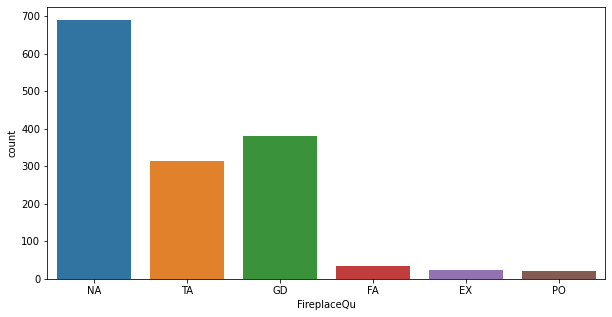

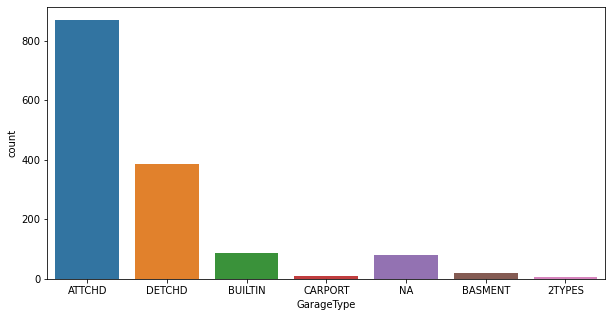

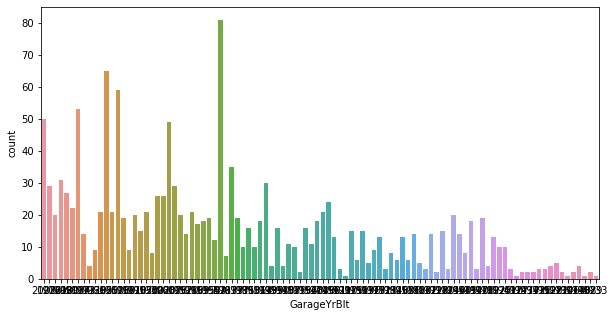

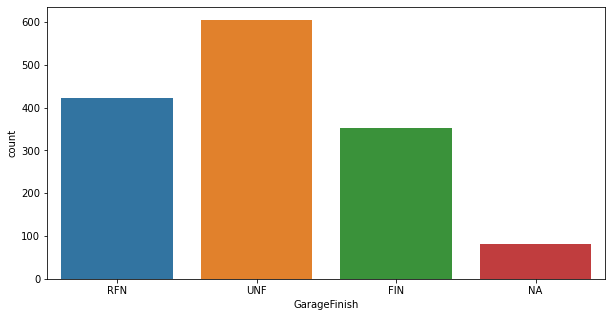

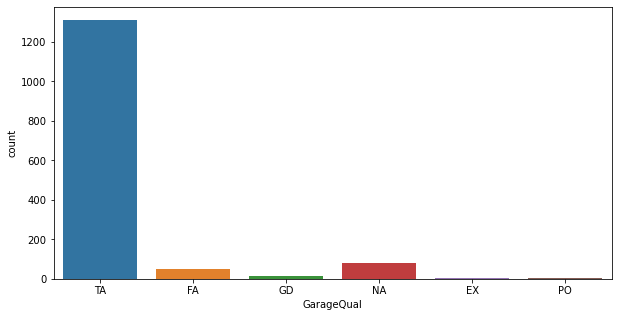

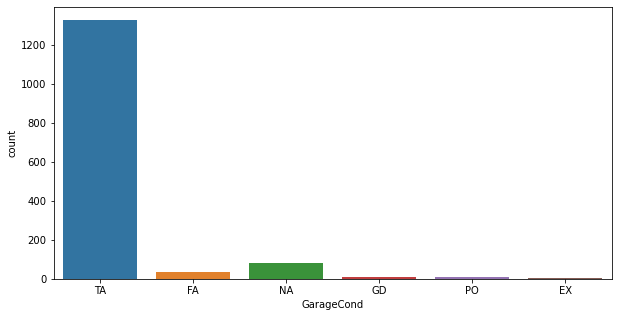

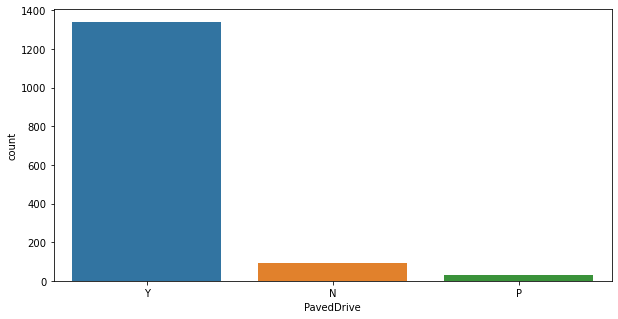

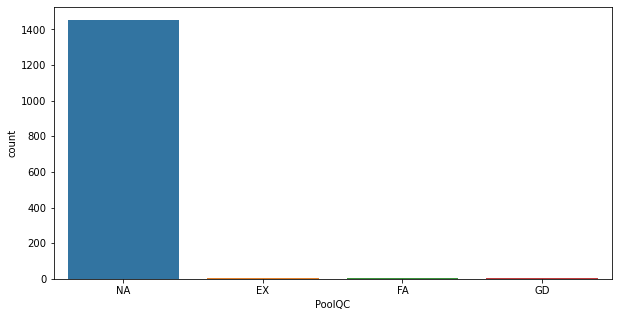

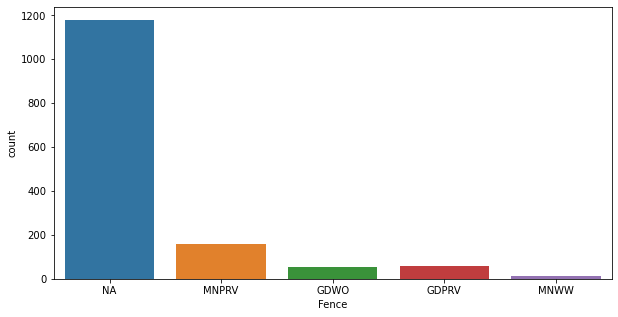

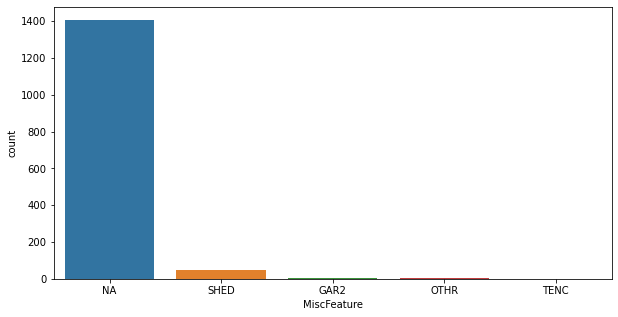

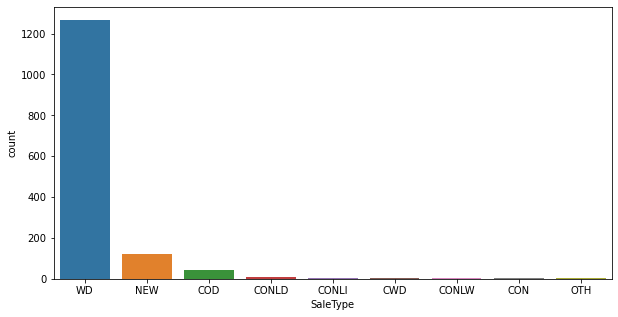

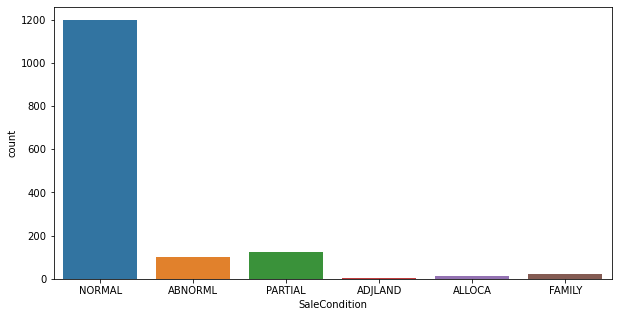

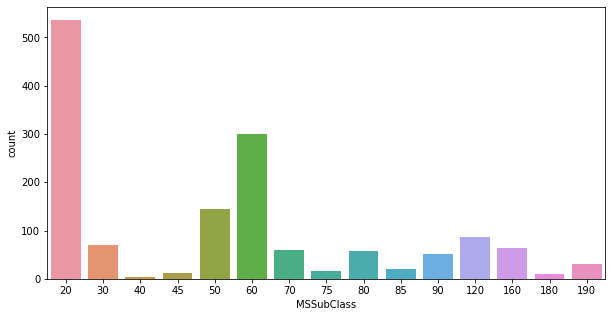

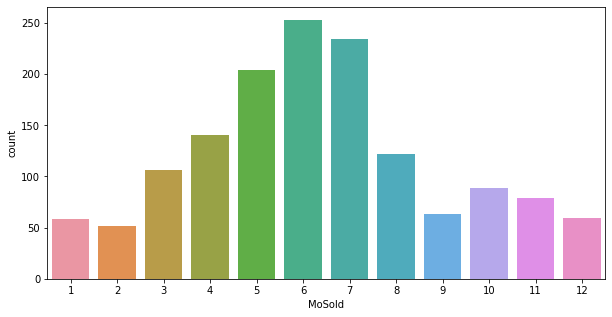

In [18]:
# check the frequency of categories in categorical variables 
for item in category_vars:
    plt.figure(figsize = (10,5))
    sns.countplot(sub_data[item])

We can see that some variables are having high class imbalance. They won't add any useful info to the model, and hence can be dropped. Variables: Street, Utilities, RoofMatl, Heating, Condition2, PoolQC

In [19]:
sub_data.drop(labels = ['Street', 'Utilities', 'RoofMatl','Heating', 'Condition2','PoolQC'],axis = 1 , inplace =True)
category_vars =  list(category_vars)
for item in ['Street', 'Utilities', 'RoofMatl','Heating', 'Condition2','PoolQC']:
    category_vars.remove(item)
sub_data.shape

(1460, 74)

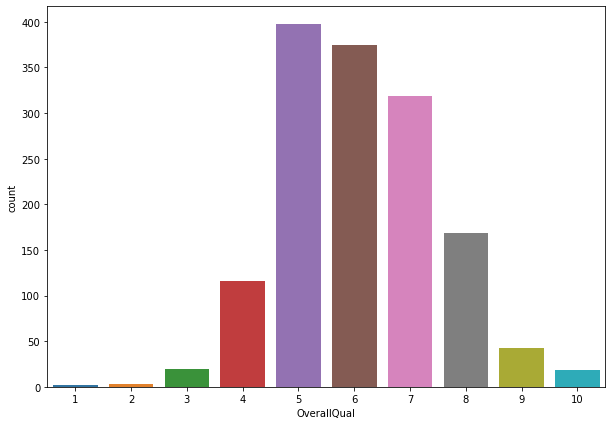

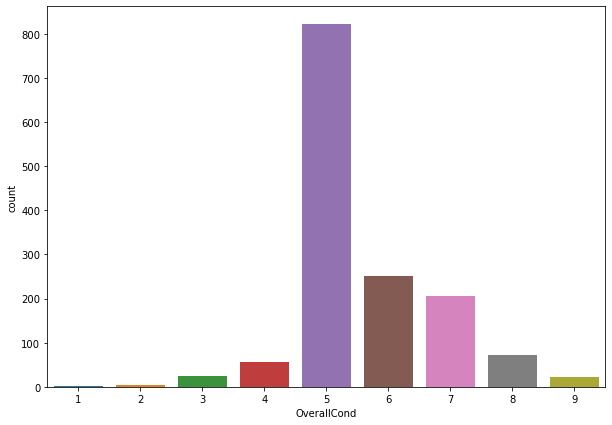

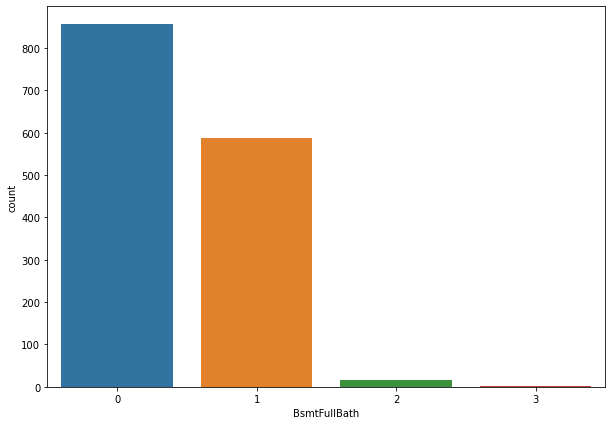

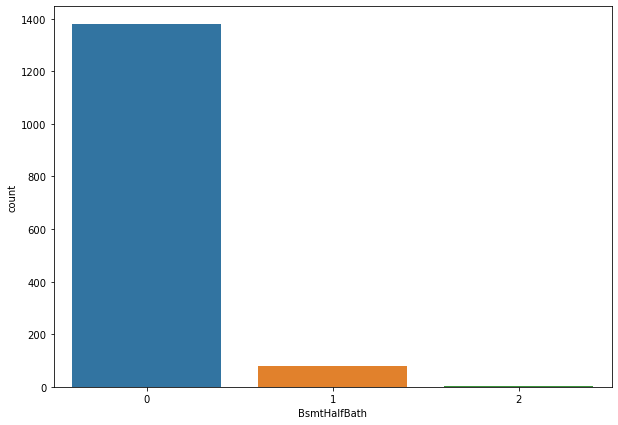

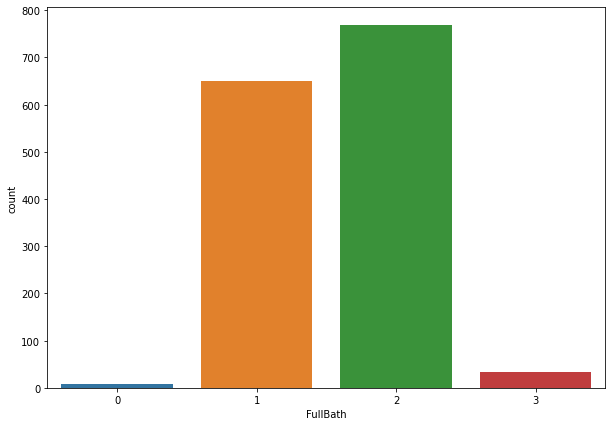

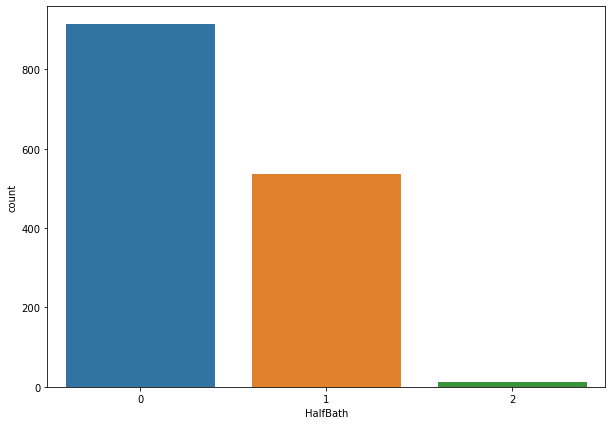

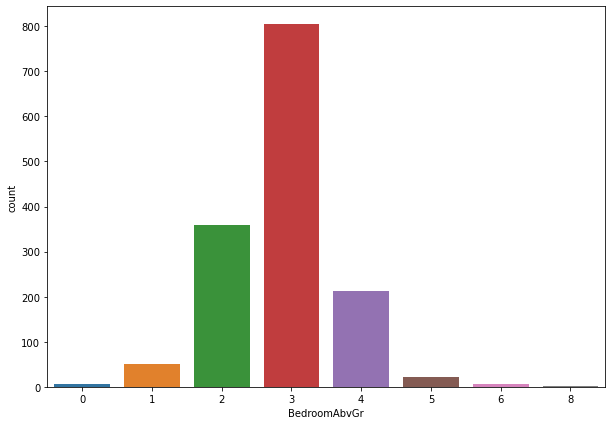

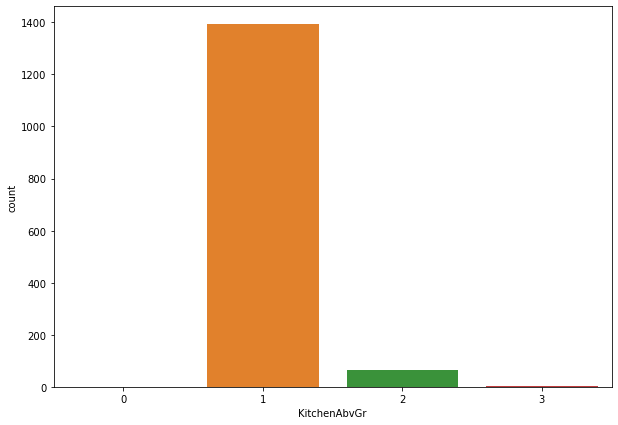

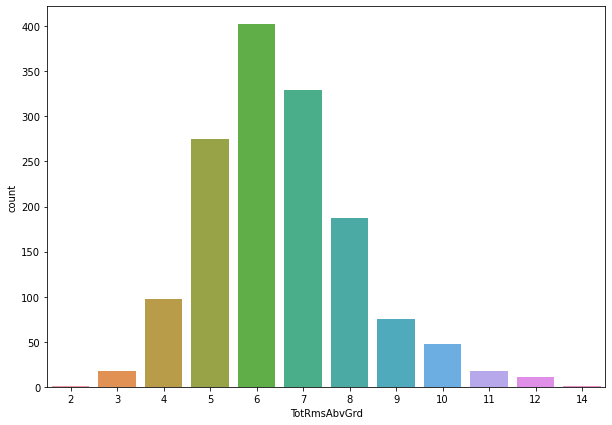

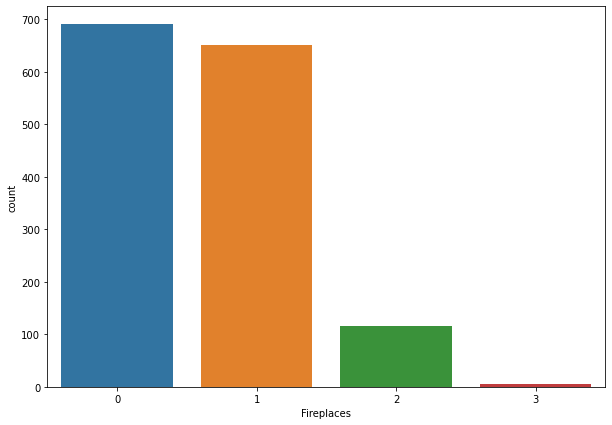

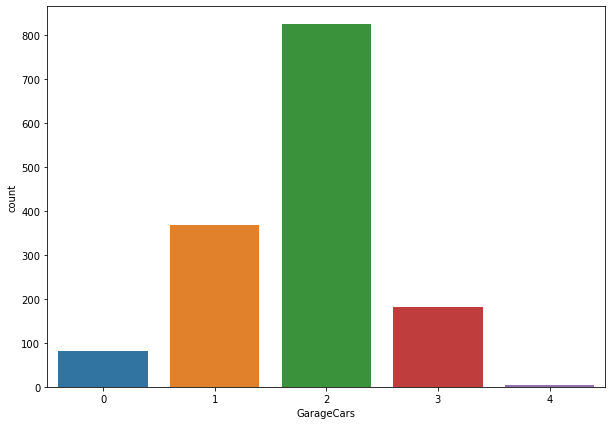

In [20]:
# check frequency plot for ordered categorical variables
for item in ord_cate_vars:
    plt.figure(figsize = (10,7))
    sns.countplot(sub_data[item])

check the distribution of traget varaible - SalePrice

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


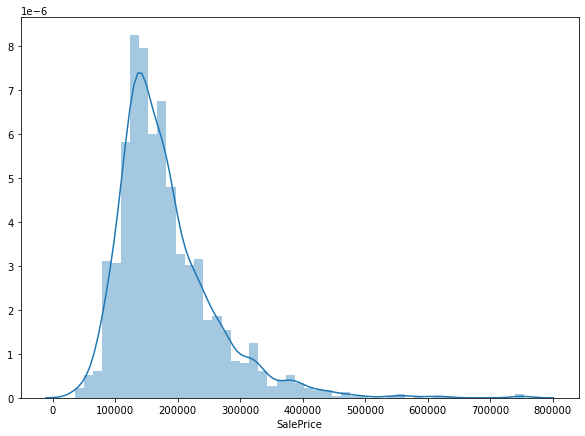

In [21]:
print(sub_data.SalePrice.describe())
plt.figure(figsize = (10,7))
sns.distplot(sub_data.SalePrice)

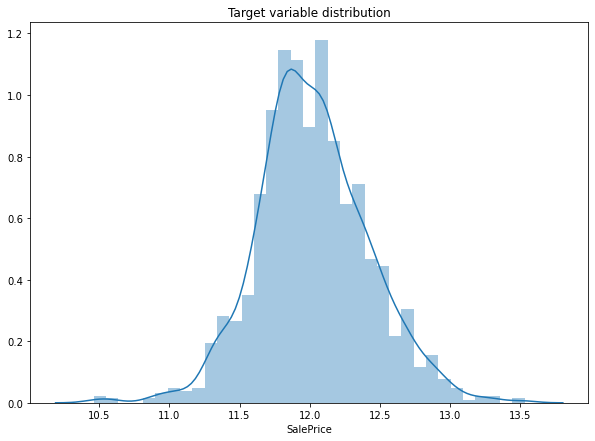

In [22]:
# There are outliers in SalePrice. Take the log transformation of the variable and observe the distribution. 
plt.figure(figsize = (10,7))
plt.title('Target variable distribution')
sns.distplot(np.log(sub_data.SalePrice))

#### Derived Metrics

In [23]:
#Since log transformation is independent of test and train data, we can perform this on the entire dataset together.
sub_data['log_SalePrice'] = np.log(sub_data.SalePrice)
sub_data.drop('SalePrice',axis = 1, inplace = True)
cont_vars.remove('SalePrice')
cont_vars.append('log_SalePrice')

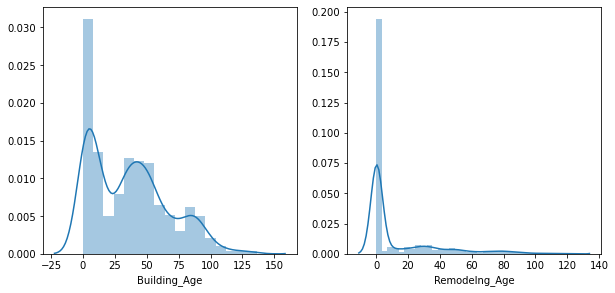

In [24]:
# Derive age metric for building, remodelling
sub_data['Building_Age'] = sub_data.YrSold - sub_data.YearBuilt
sub_data['Remodelng_Age'] = sub_data.YearRemodAdd - sub_data.YearBuilt
plt.figure(figsize = (10,10))
plt.subplot(2,2,1)
sns.distplot(sub_data.Building_Age)
plt.subplot(2,2,2)
sns.distplot(sub_data.Remodelng_Age)

In [25]:
print((sub_data.YearBuilt == sub_data.YrSold).sum())
print((sub_data.Building_Age == 0).sum())

64
64


We  can see 64 cases are having the built year and sold year the same. So the building age is coming out to be 0. But the age might be in terms of months for these cases. Since we only have the sold month details but not contructed month details, let's assume the age as 6 months (0.5 years) for the cases with Building_Age 0.

In [26]:
# data imputation as per above business logic
sub_data.Building_Age = sub_data.Building_Age.replace({0:0.5})
(sub_data.Building_Age == 0.5).sum()

64

In [27]:
sub_data.GarageYrBlt =sub_data.GarageYrBlt.replace({'NA':0})
sub_data.GarageYrBlt = sub_data.GarageYrBlt.astype('int64')
sub_data['Garage_Age'] =sub_data.YrSold - sub_data.GarageYrBlt

Entries in Garage_Age would be 0 if the GarageBltYr and YrSold are same. So let's assume that it would take atleast 3 months (0.25 year) to build a Garage. Let's impute the 0 value entries with this. 

Also, there will be a few entries where GarageBltYr was 0, indicating absence of Garage. Hence the Garage_Age column would have the same value of YrSold. Let's update these values with 0, to represent 'No Garage'.

In [28]:
# data imputation as per above business logic
print(sub_data.Garage_Age.sort_values())
sub_data.Garage_Age = sub_data.Garage_Age.replace({0:0.25})
sub_data.loc[sub_data.Garage_Age == sub_data.YrSold,'Garage_Age'] = 0
sub_data.Garage_Age.value_counts()

798        0
117        0
1217       0
112        0
443        0
        ... 
960     2010
1137    2010
250     2010
99      2010
1283    2010
Name: Garage_Age, Length: 1460, dtype: int64


1.00      87
0.25      84
0.00      81
4.00      45
2.00      35
          ..
100.00     1
102.00     1
76.00      1
94.00      1
91.00      1
Name: Garage_Age, Length: 102, dtype: int64

In [29]:
# remove all the variables which were used to derive new variables 
sub_data.drop(labels = ['YrSold', 'YearBuilt', 'YearRemodAdd','GarageYrBlt'], axis = 1, inplace = True)
cont_vars.remove('YrSold')
cont_vars.remove('YearBuilt')
cont_vars.remove('YearRemodAdd')
category_vars.remove('GarageYrBlt')
cont_vars.append('Building_Age')
cont_vars.append('Remodelng_Age')
cont_vars.append('Garage_Age')

We can also create derived metrics by combining 'HalfBath' and 'FullBath', 'BsmtFullBath' and 'BsmtHalfBath', etc. But let's see the peroformance of the model on the current datset. And if needed, we can create more derived metrics later.

<ipython-input-30-b877462d21b7>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize = (10,7))
<ipython-input-30-b877462d21b7>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize = (10,7))
<ipython-input-30-b877462d21b7>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize = (10

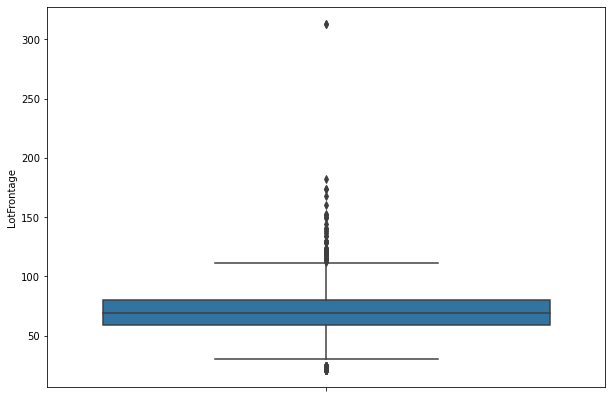

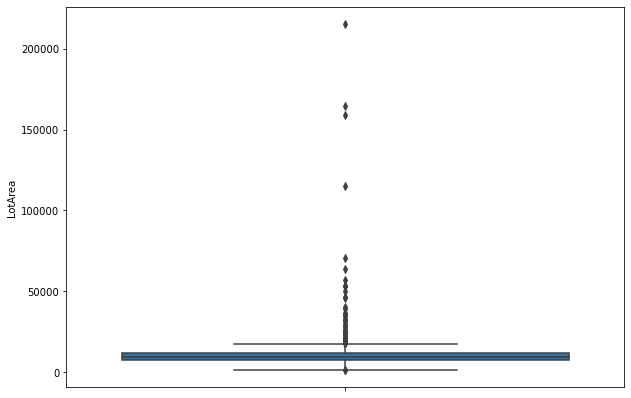

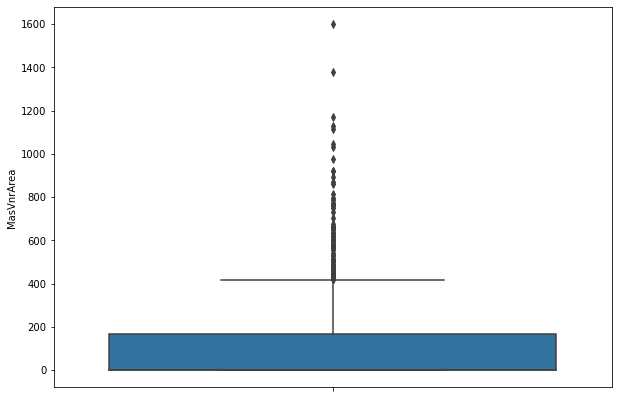

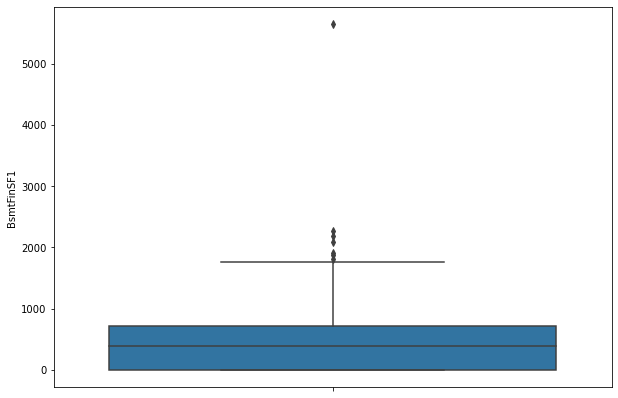

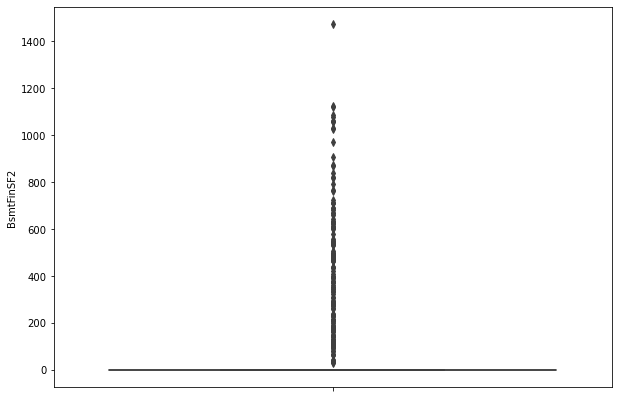

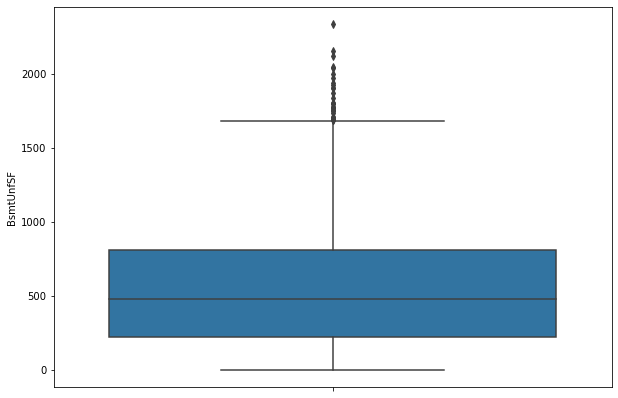

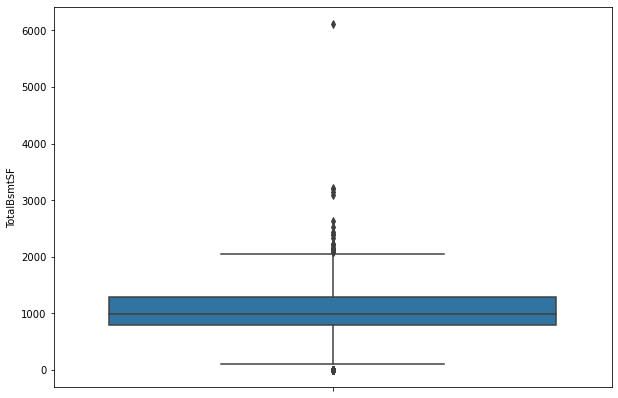

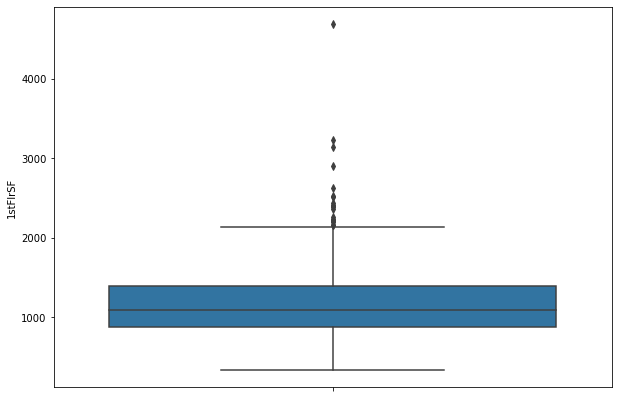

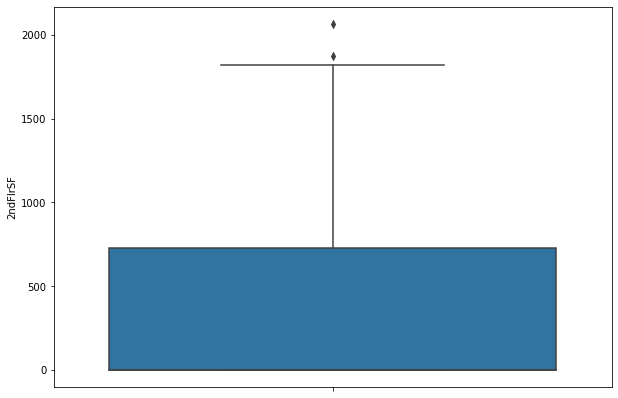

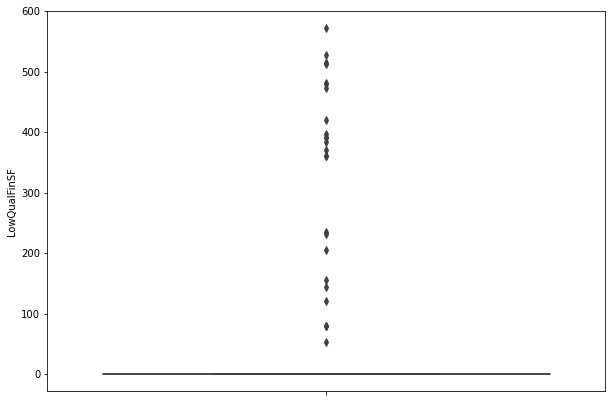

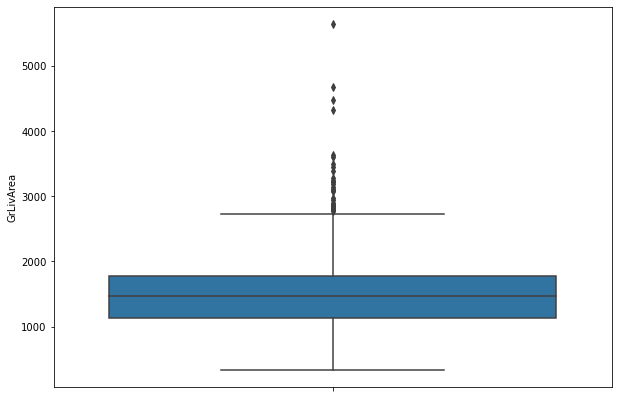

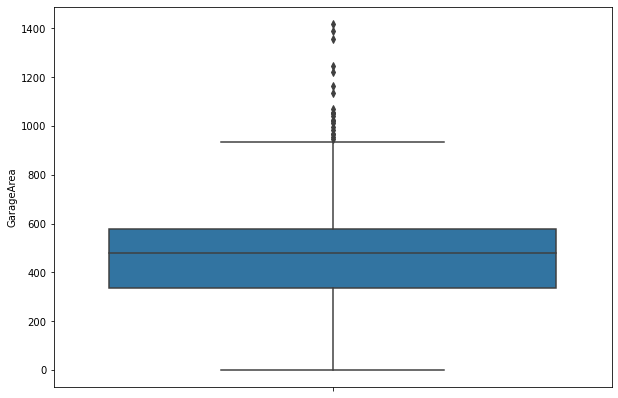

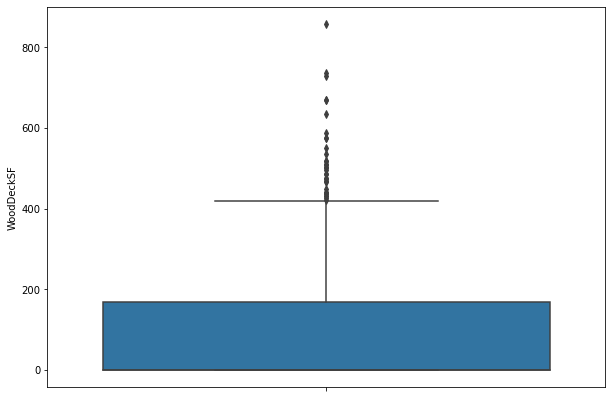

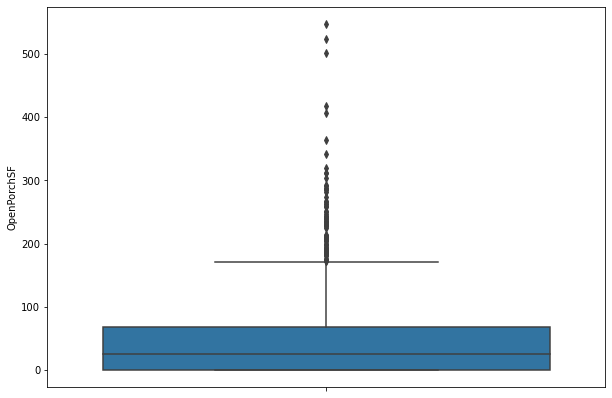

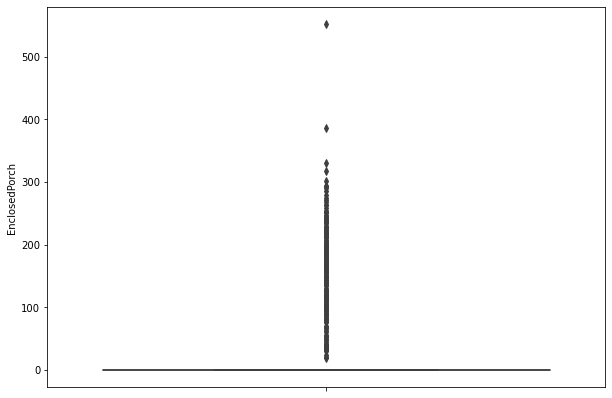

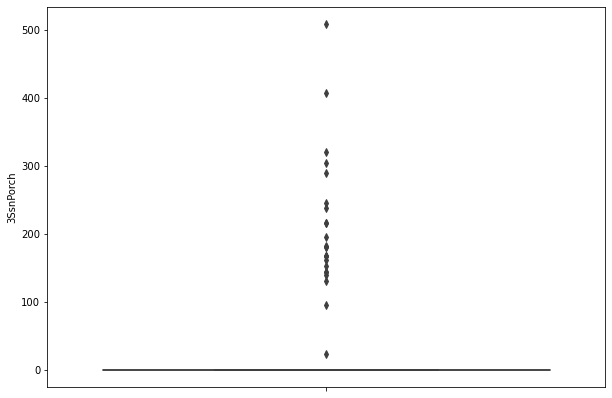

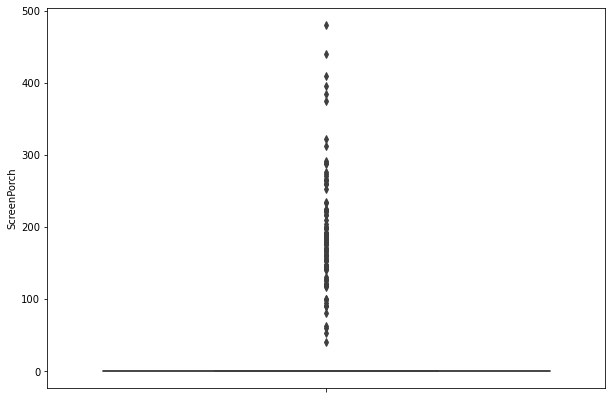

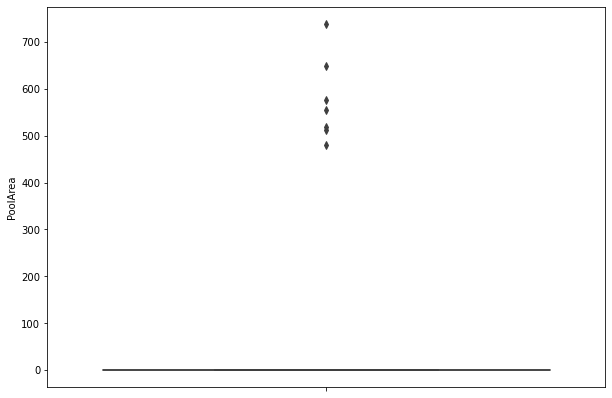

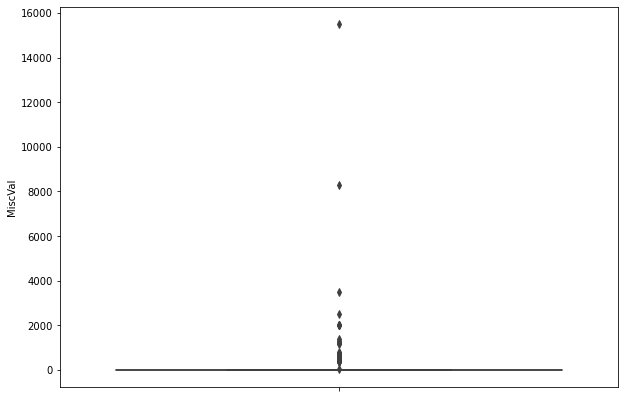

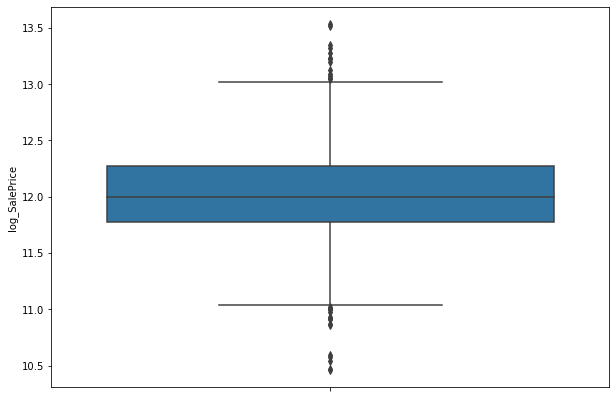

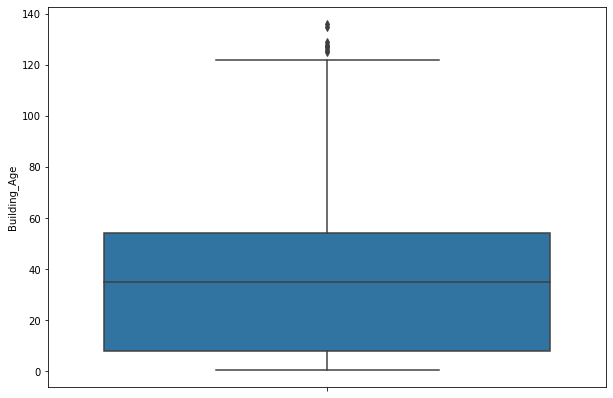

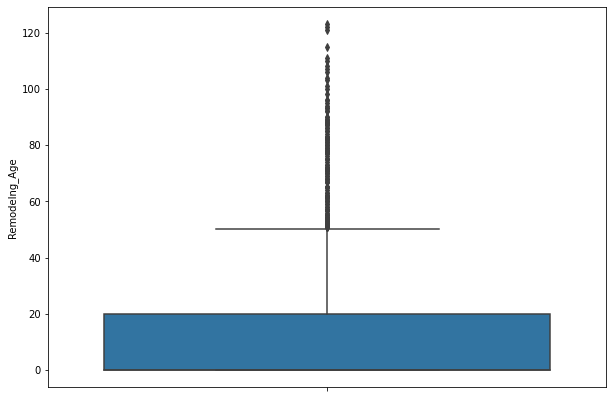

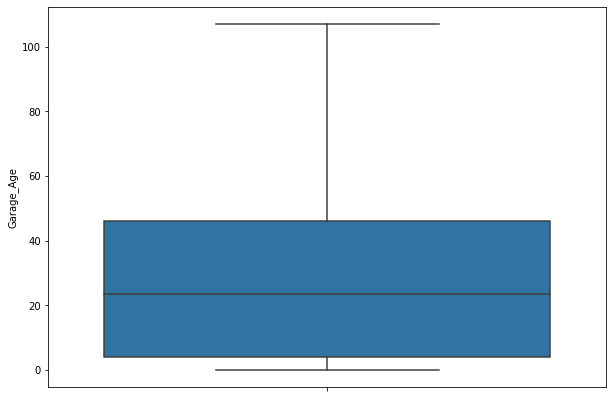

In [30]:
# check the distribution of continuous variable
for item in cont_vars:
    plt.figure(figsize = (10,7))
    sns.boxplot(sub_data[item], orient='v')

Many of the variables are having outliers in them. This has to be resolved on train set and then on test data. 

### Bivariate Analysis
let's look at the following details:
       1. Correlation of variables
       2. variation in SalePrice against few of the major variables

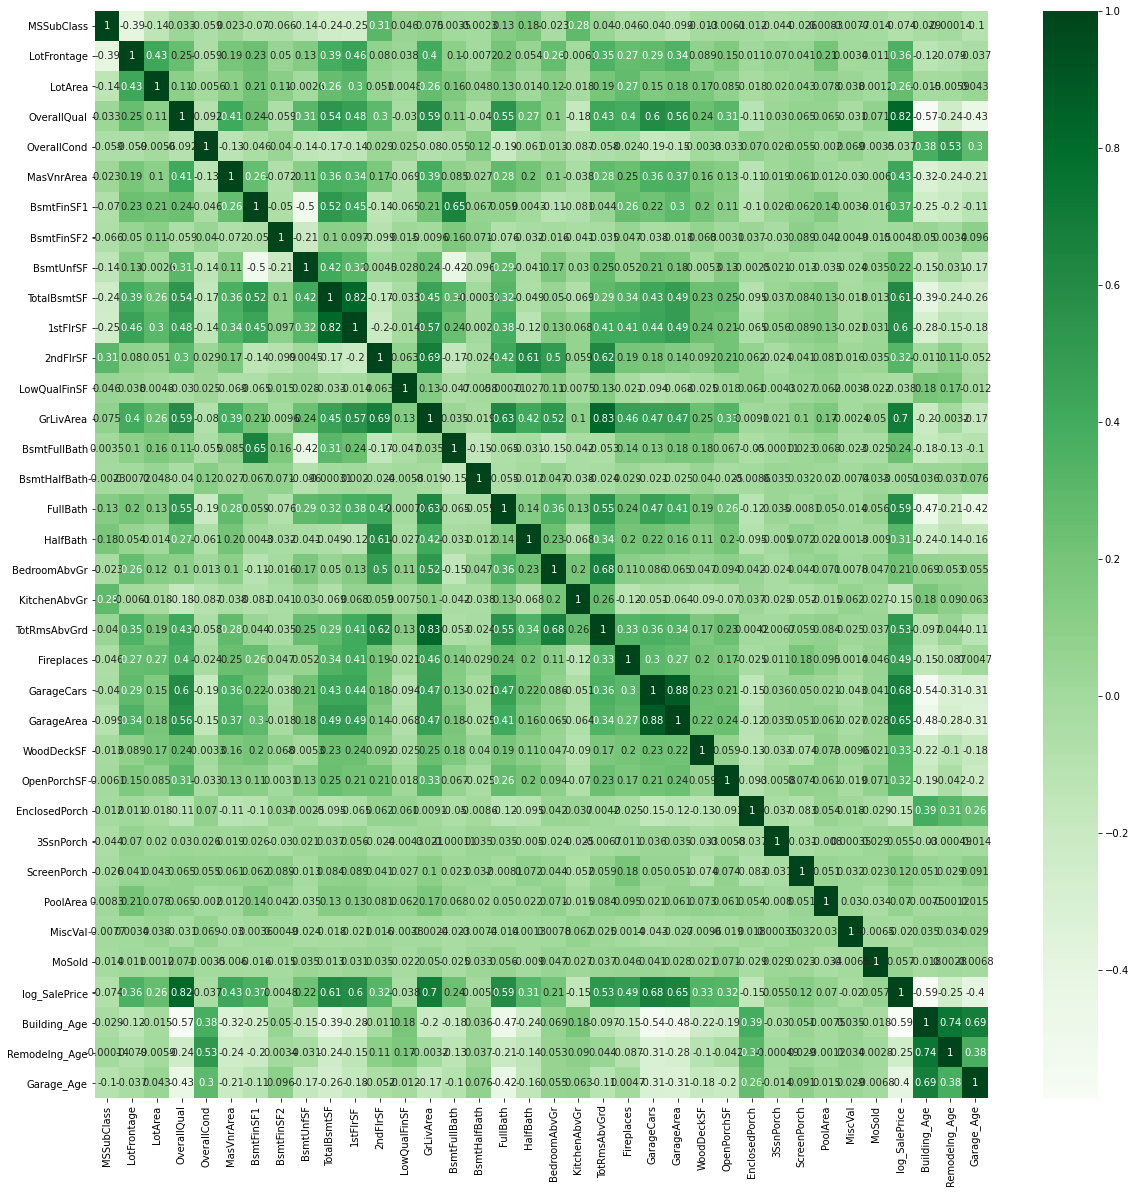

In [31]:
plt.figure(figsize = (20,20))
sns.heatmap(sub_data.corr(), cmap ='Greens', annot = True)

We can see that a few variables are having a correlation value greater than 0.8. Hence we can drop one of the correlated vars. We can keep the one which makes more sense from business perspective.
- Vars with high correlation: 
    - 1stFlrSF and TotalBsmtSF - 1stFlrSF represent first floor SF and TotalBsmtSF represents total basement SF. Keep 1stFlrSF   and drop TotalBsmtSF
    - TotRmsAbvGrd and GrLivArea - TotRmsAbvGrd represent total no.of rooms above ground and GrLivArea represents above ground living area. Let's keep the continuous variable GrLivArea and drop the other one.
    - GarageArea and GarageCars - Let's keep the continuous variable GarageArea and drop the other one.

In [32]:
sub_data.drop(labels = ['TotalBsmtSF','TotRmsAbvGrd','GarageCars'], axis =1, inplace = True)
cont_vars.remove('TotalBsmtSF')
ord_cate_vars.remove('TotRmsAbvGrd')
ord_cate_vars.remove('GarageCars')
sub_data.shape

(1460, 70)

Check the relation of target variable with other variables

<ipython-input-33-b956e2fbb0d5>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize = (10,7))


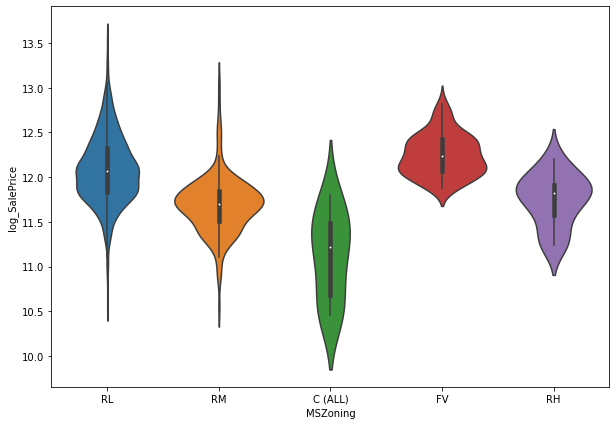

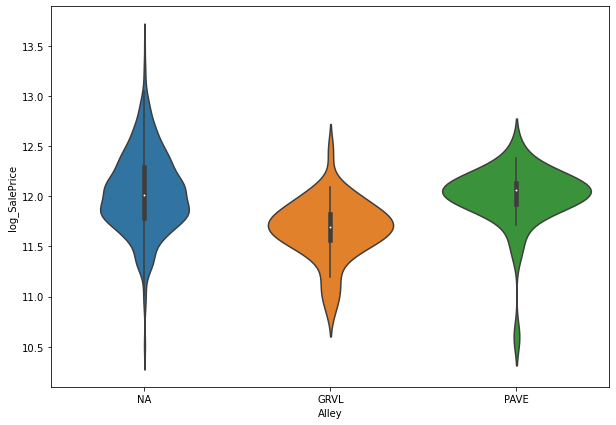

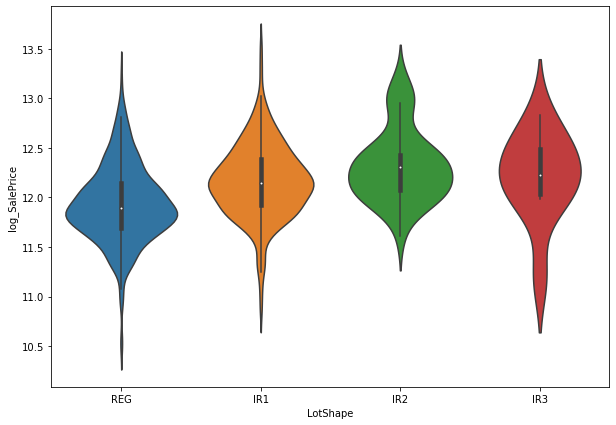

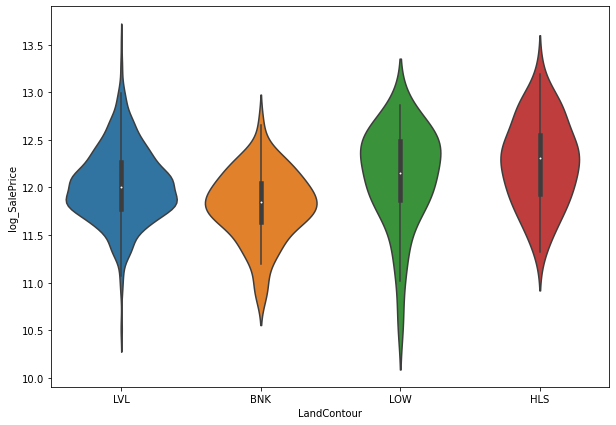

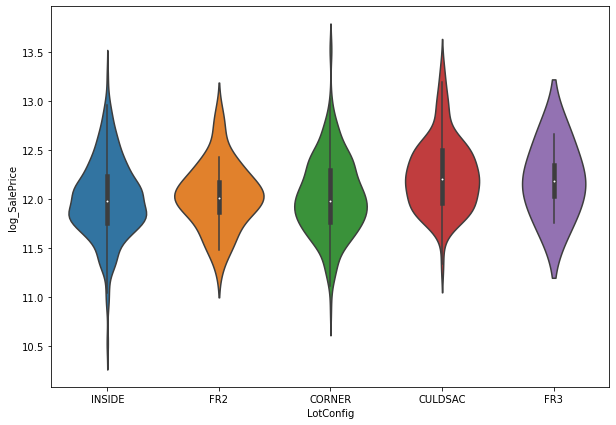

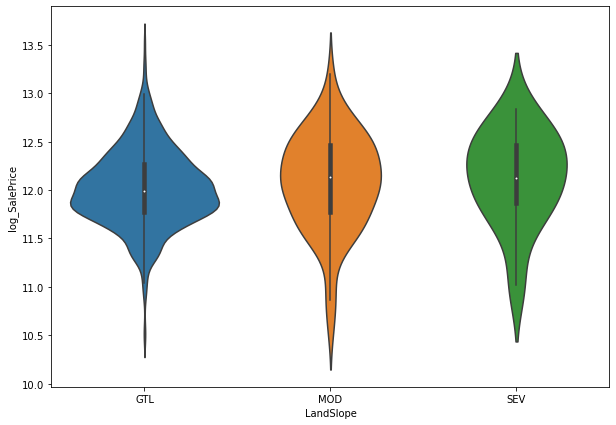

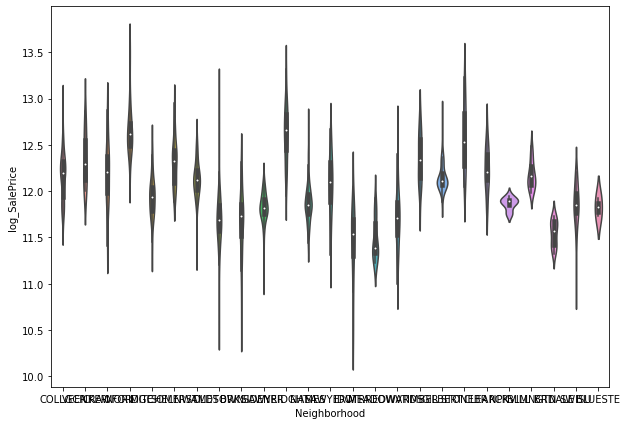

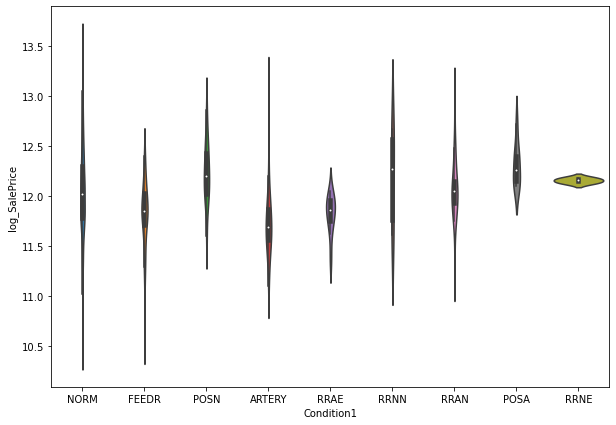

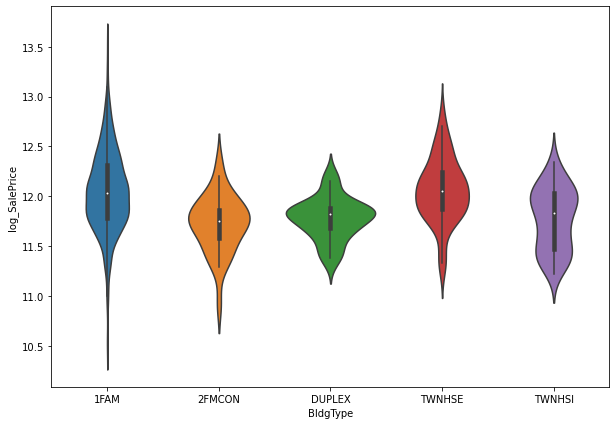

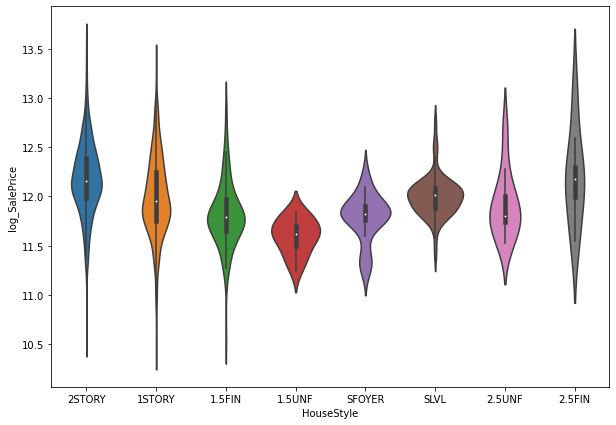

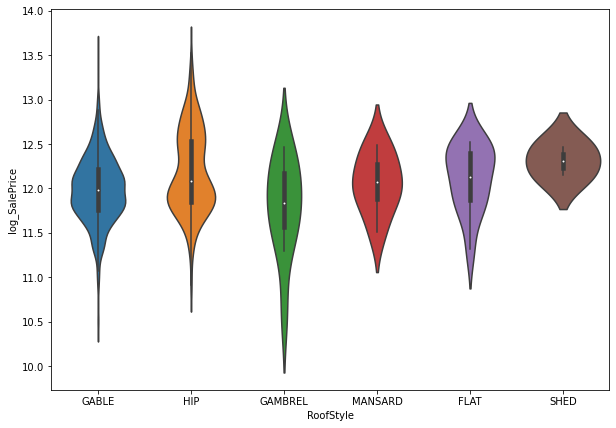

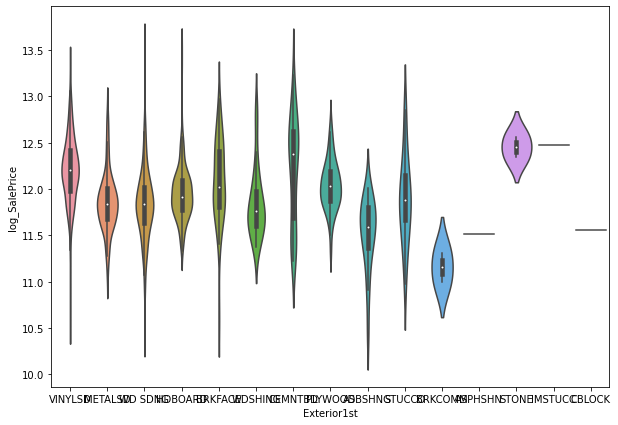

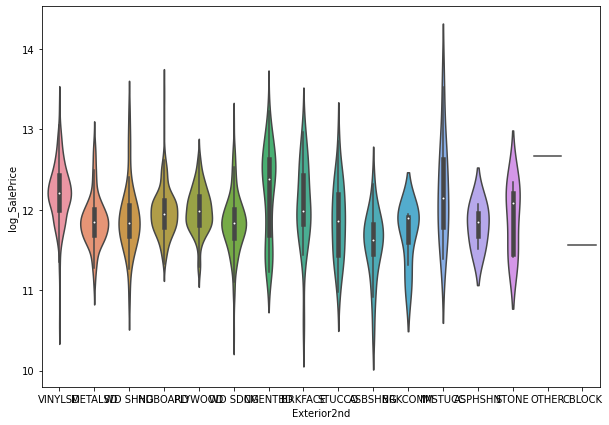

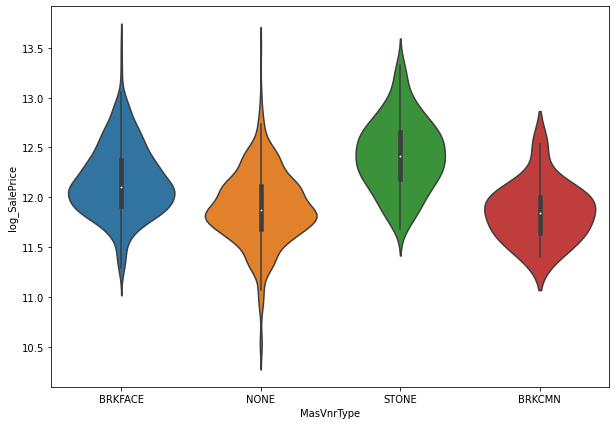

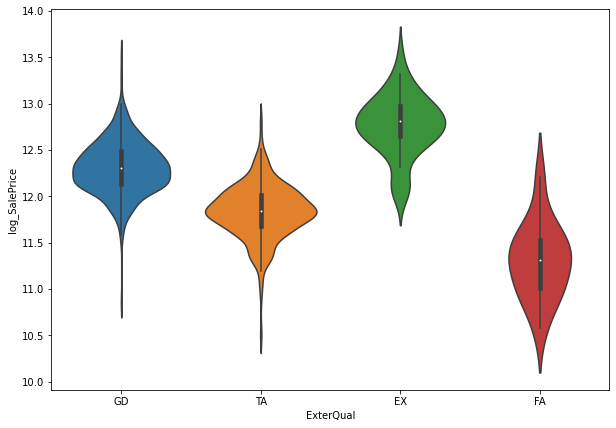

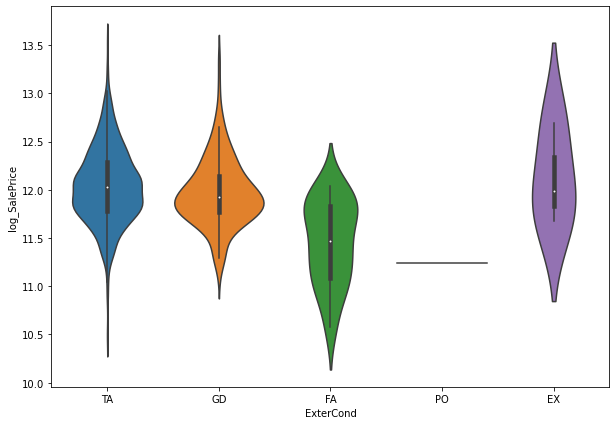

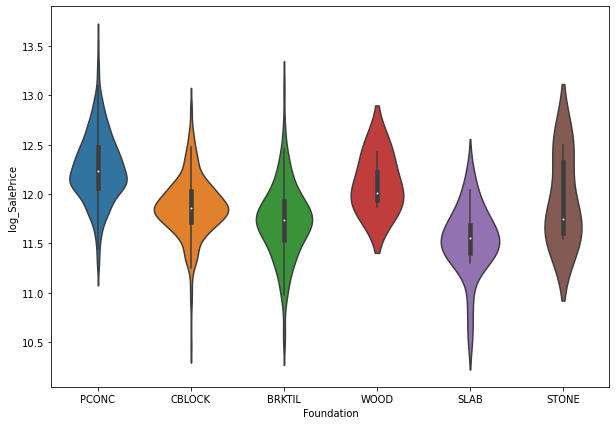

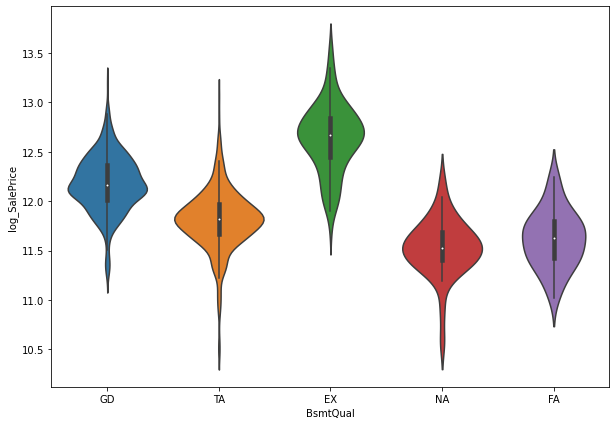

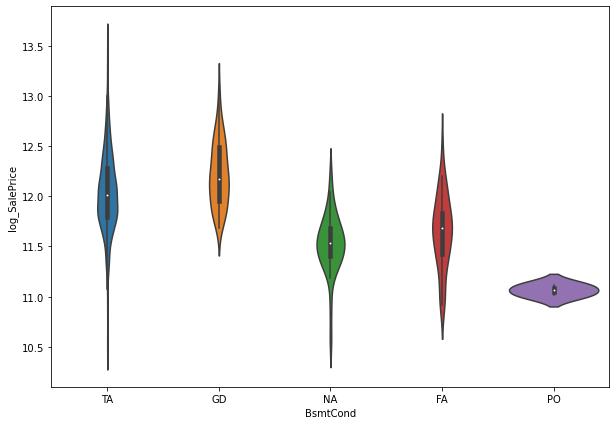

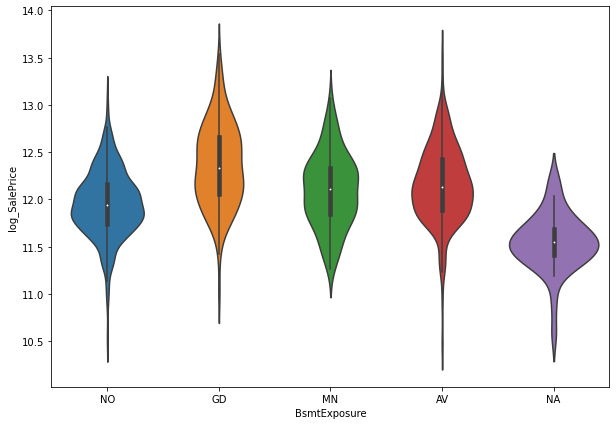

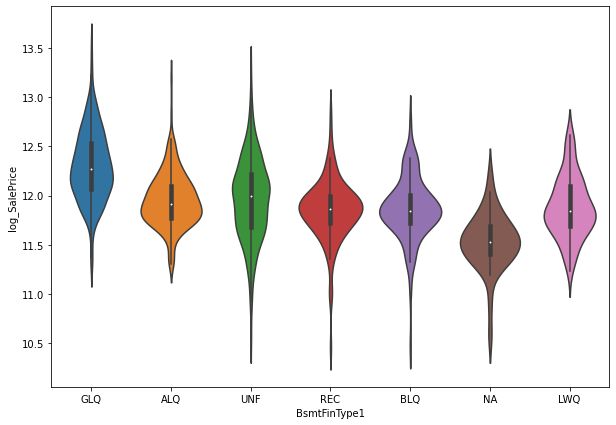

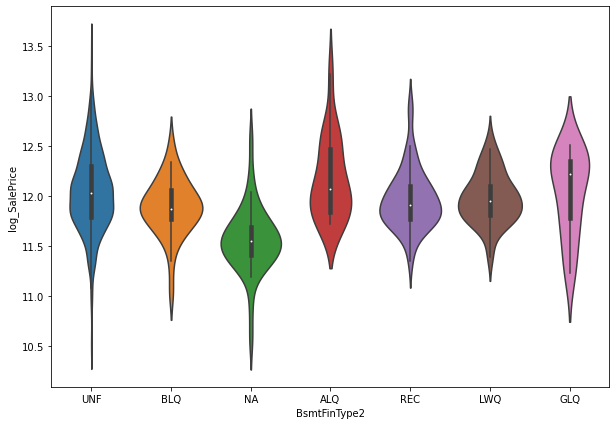

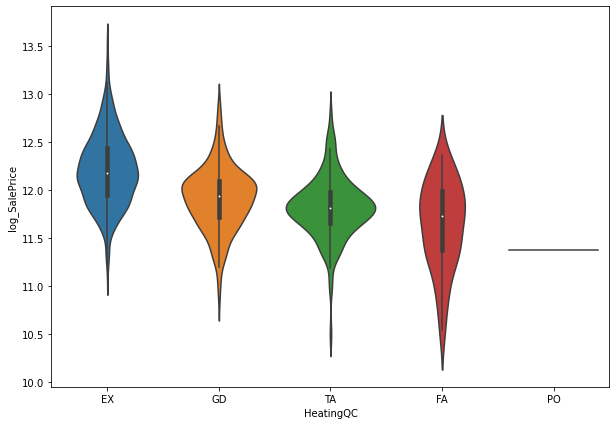

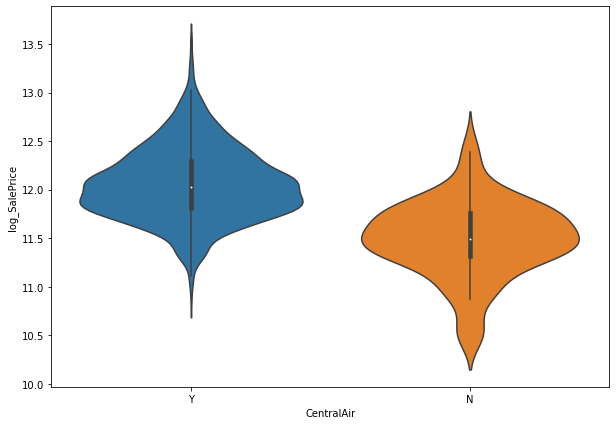

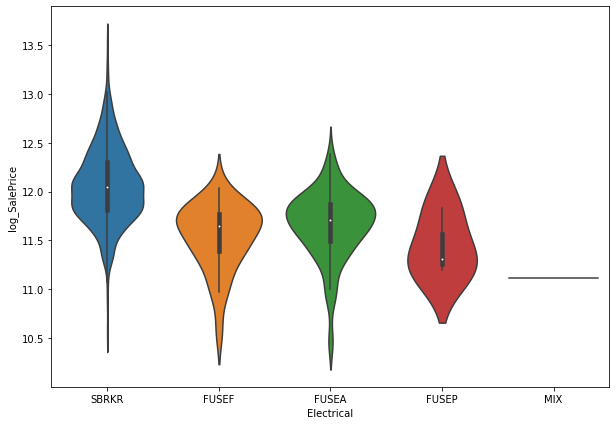

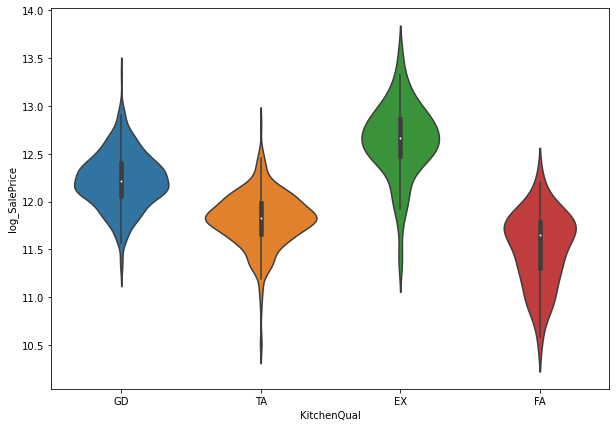

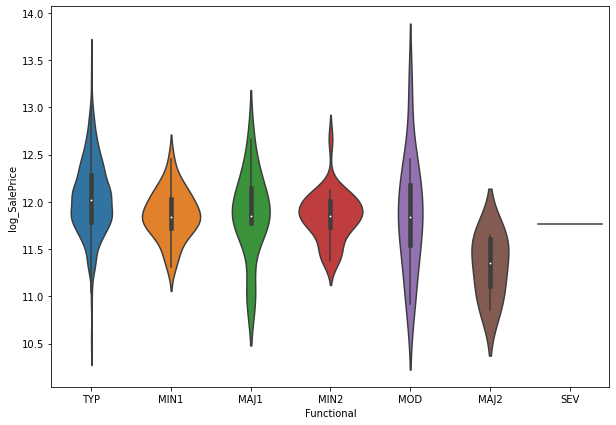

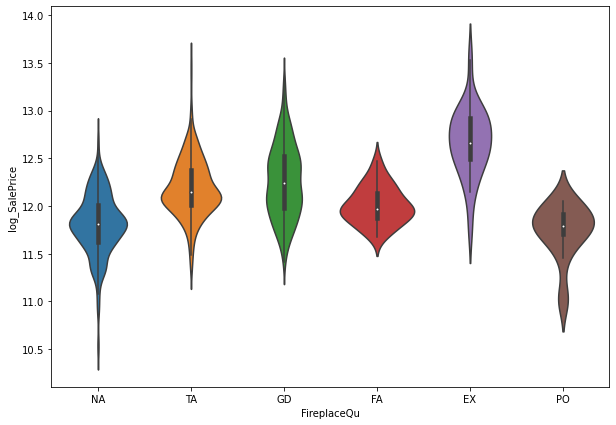

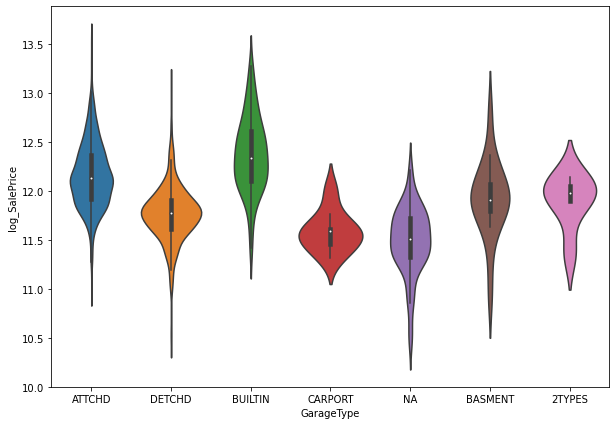

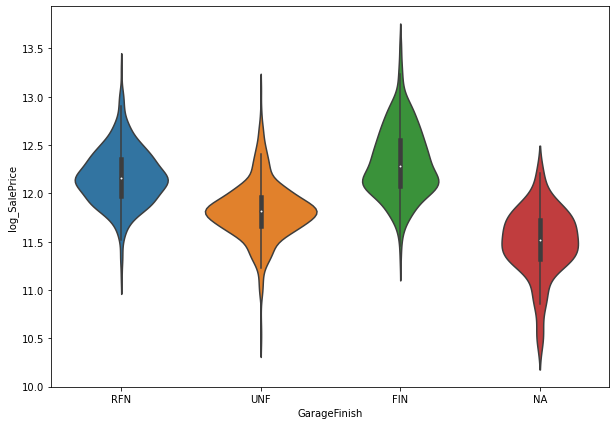

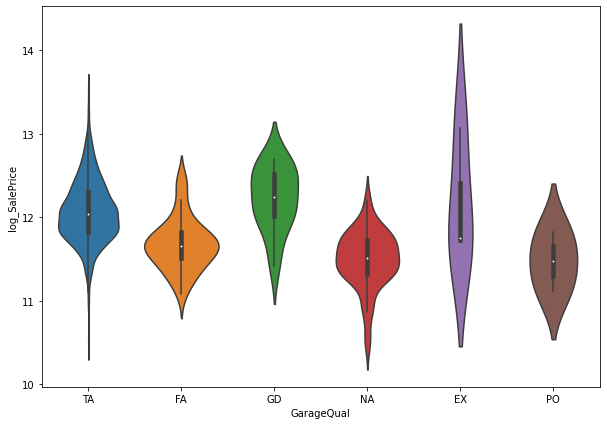

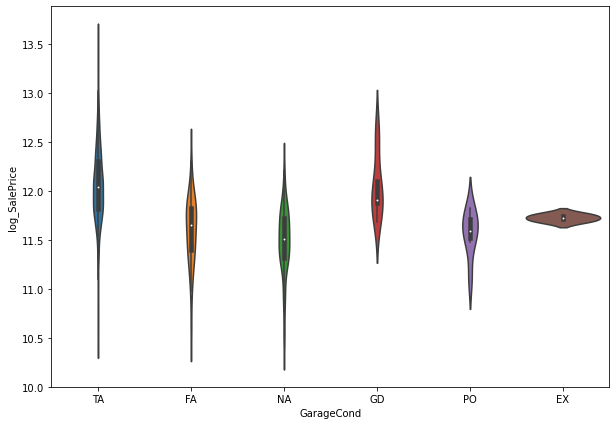

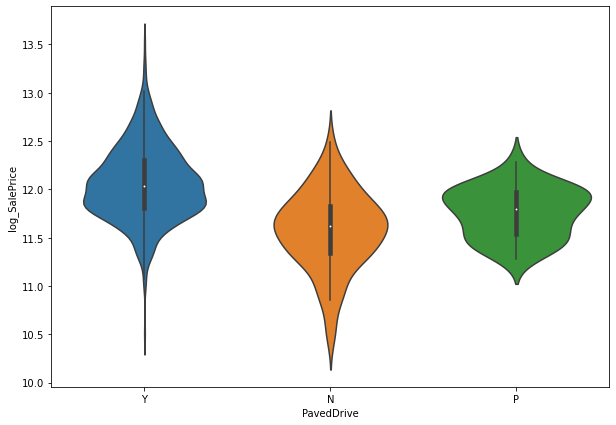

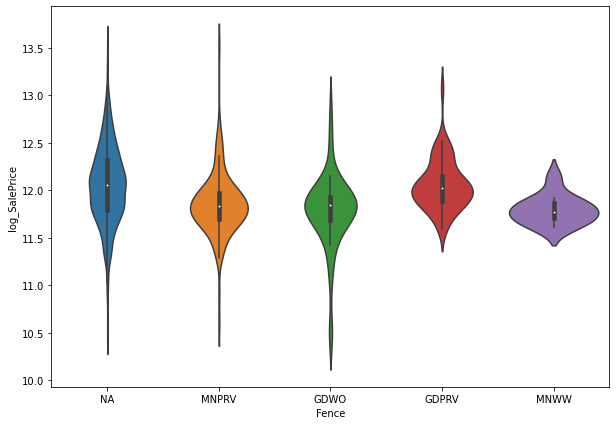

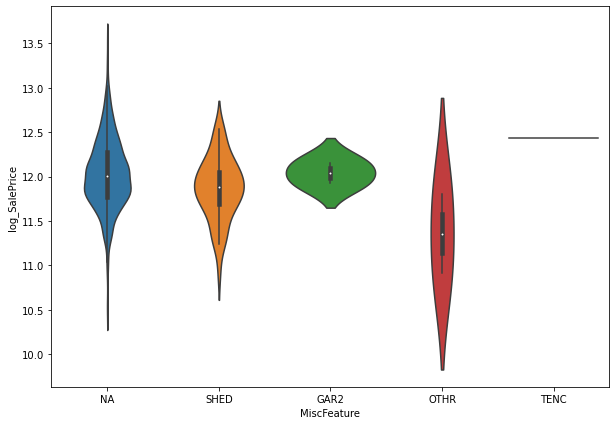

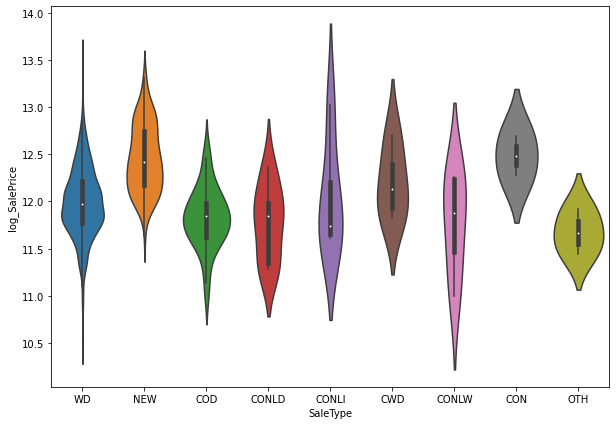

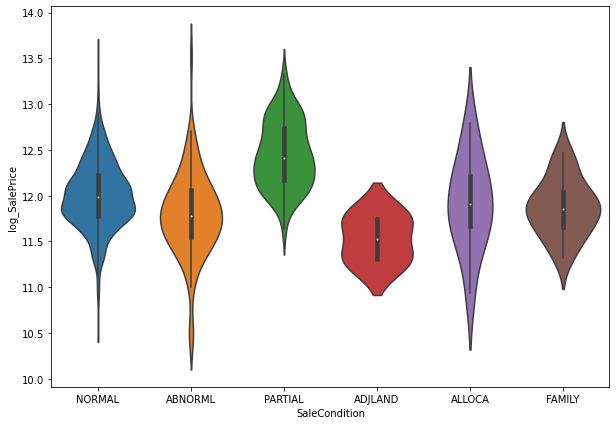

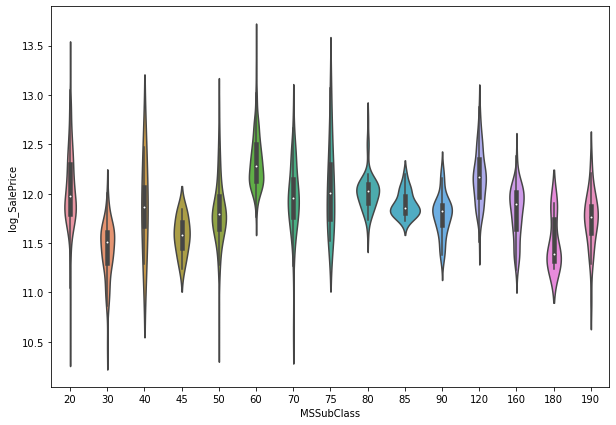

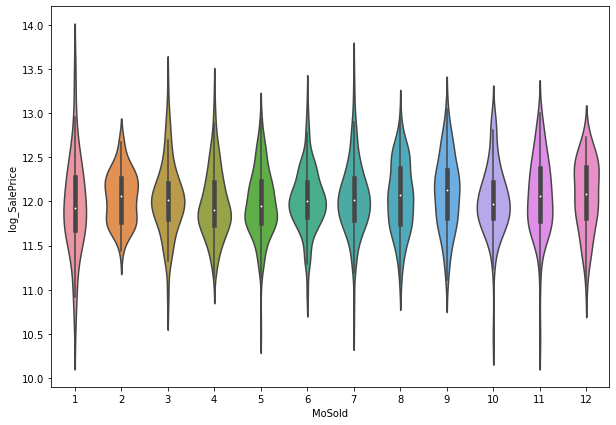

In [33]:
for item in category_vars:
    plt.figure(figsize = (10,7))
    sns.violinplot(y = sub_data.log_SalePrice, x = sub_data[item])

We can see some level of linear relationship of logSalePrice with few of the categorical variables. log_SalesPrice decreases as the Heating quality, decreases or if CentralAir conditioning is not available. Also we can see that the price increases depending on the FirePlaceQua, BsmtExposure, etc.

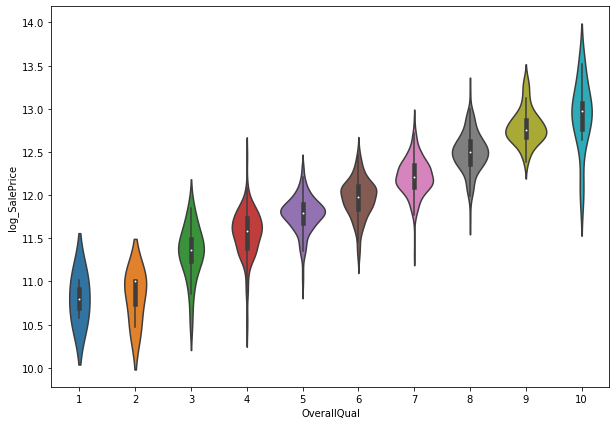

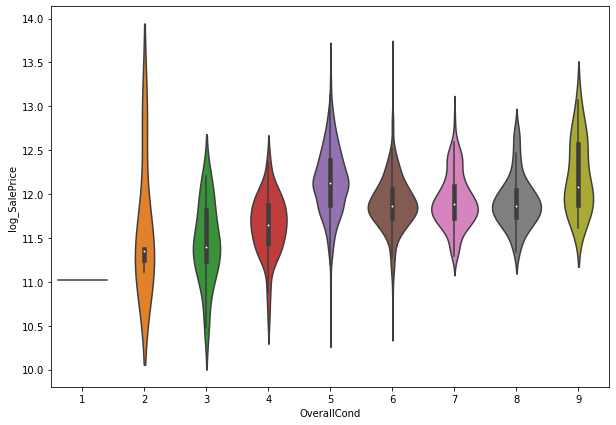

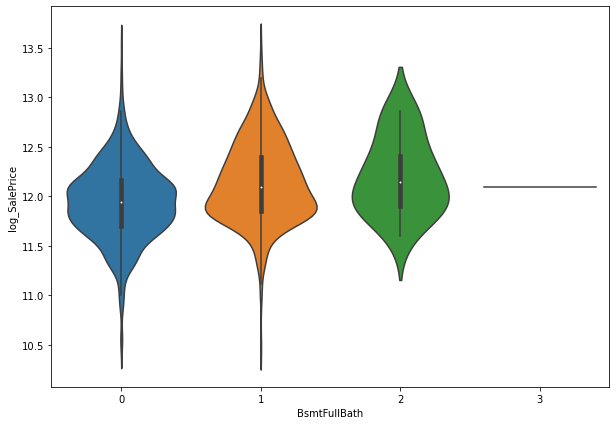

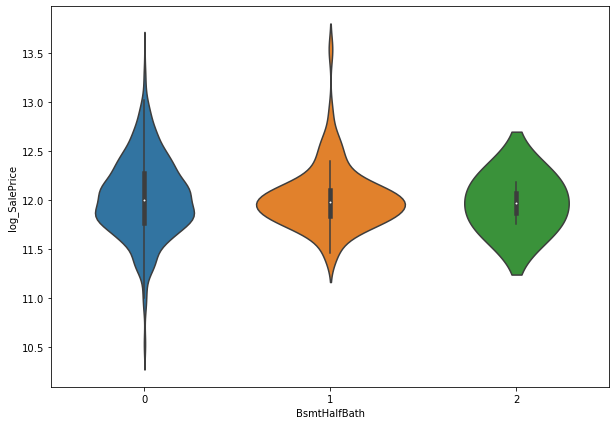

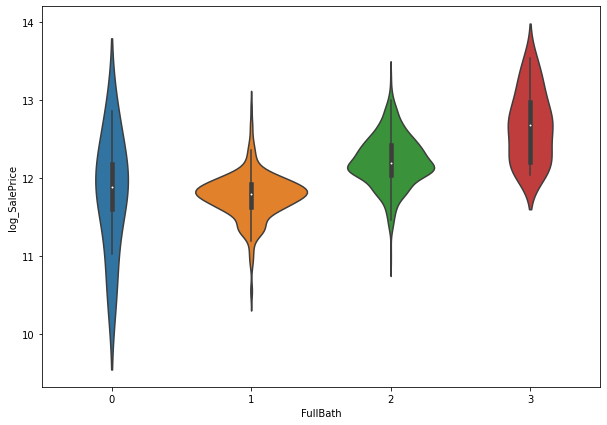

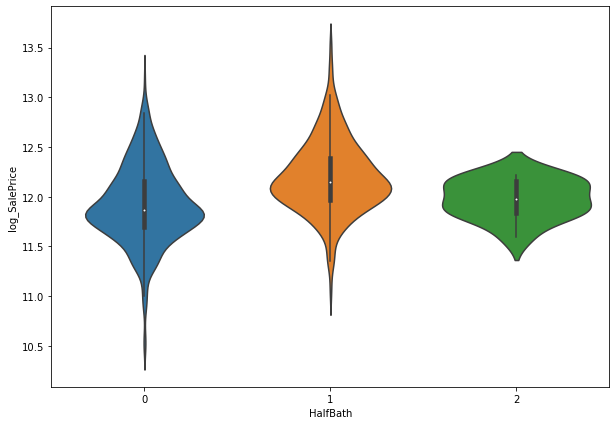

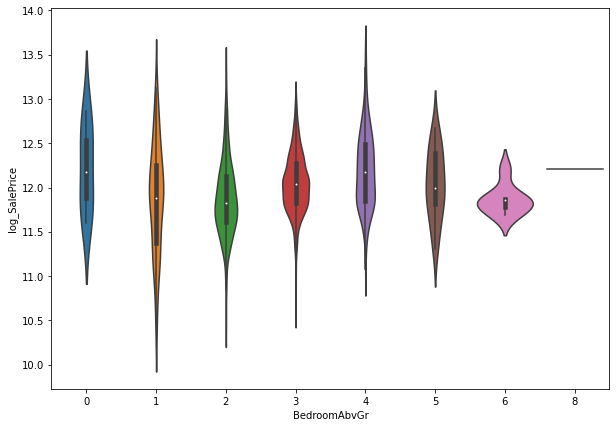

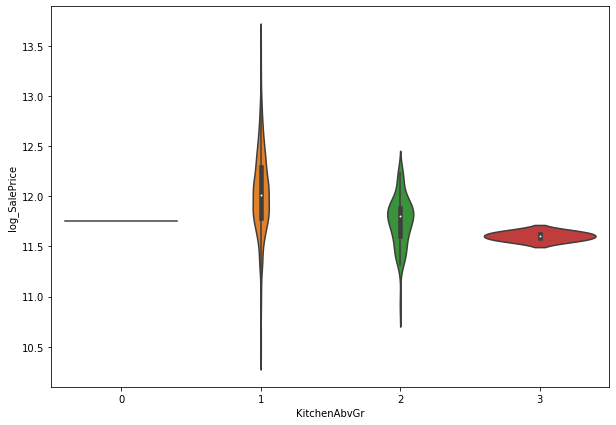

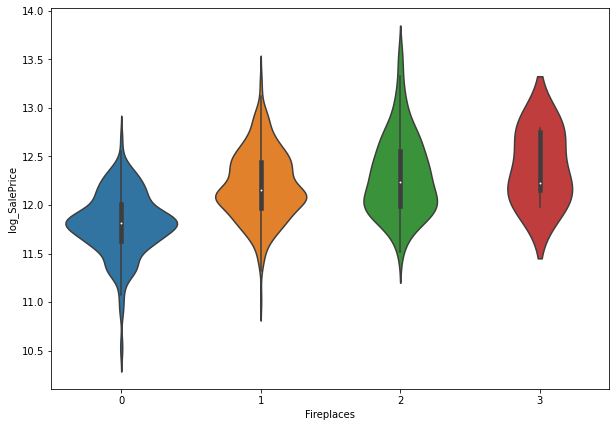

In [34]:
for item in ord_cate_vars:
    plt.figure(figsize = (10,7))
    sns.violinplot(y = sub_data.log_SalePrice, x = sub_data[item])

We can clearly see that the price increases as the OverallQual, OverallCond, FullBath, FirePlaces, etc., increases.

<ipython-input-35-a965b2cb2987>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize = (10,7))


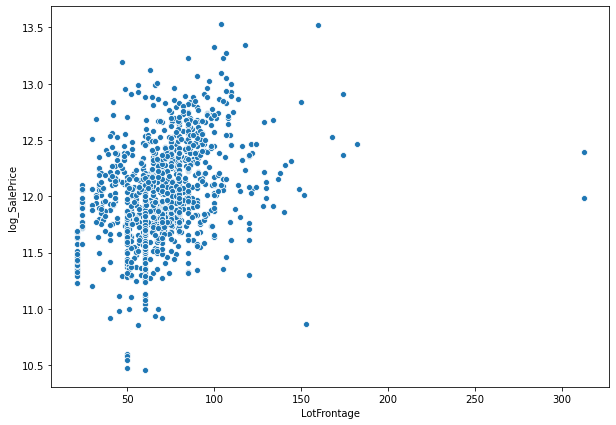

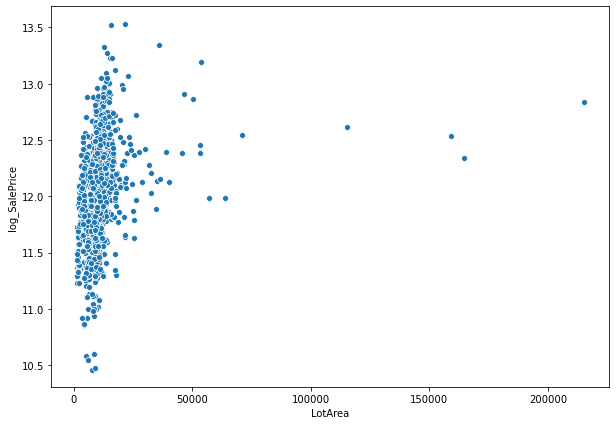

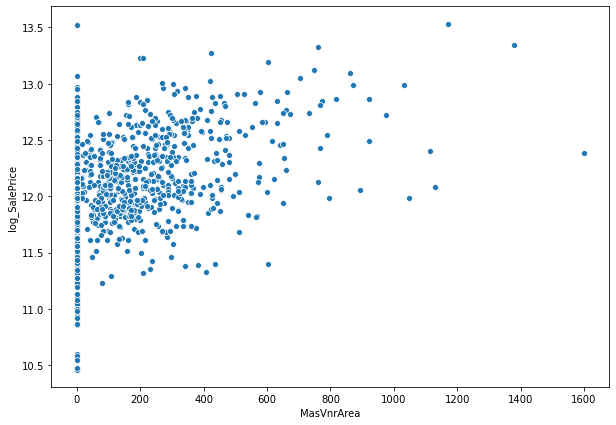

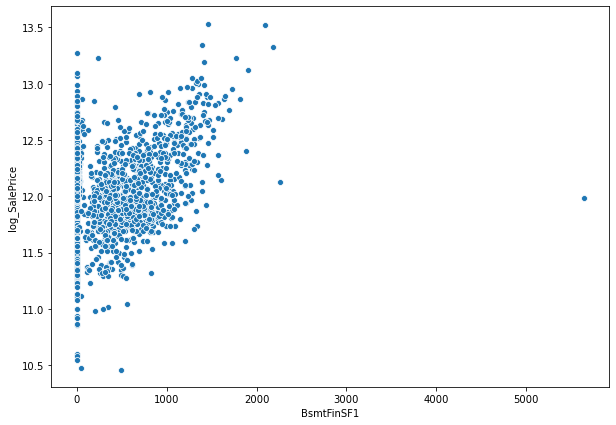

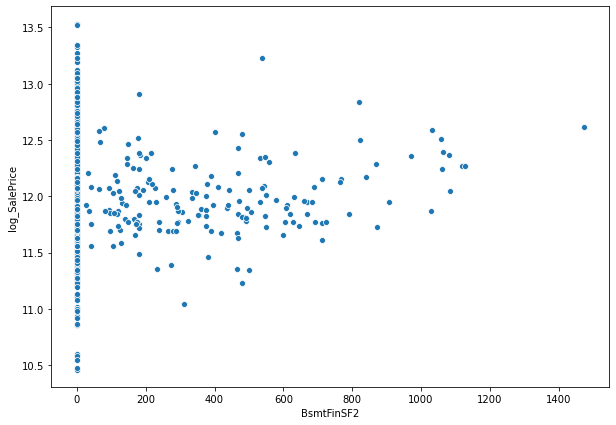

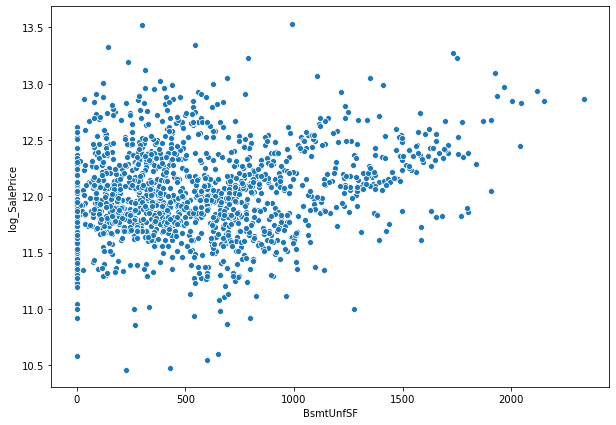

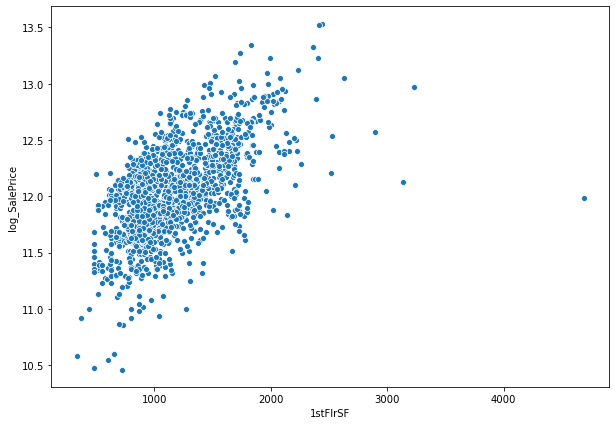

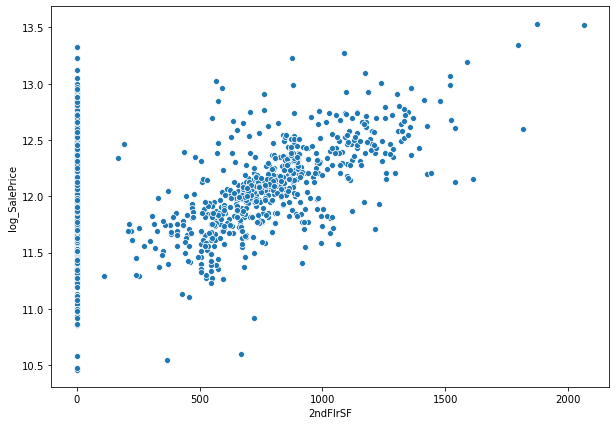

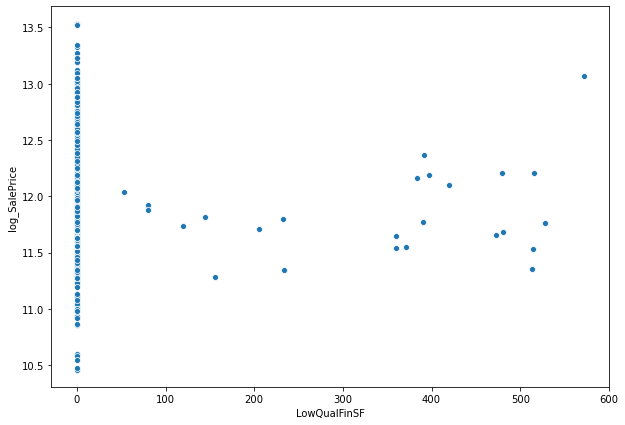

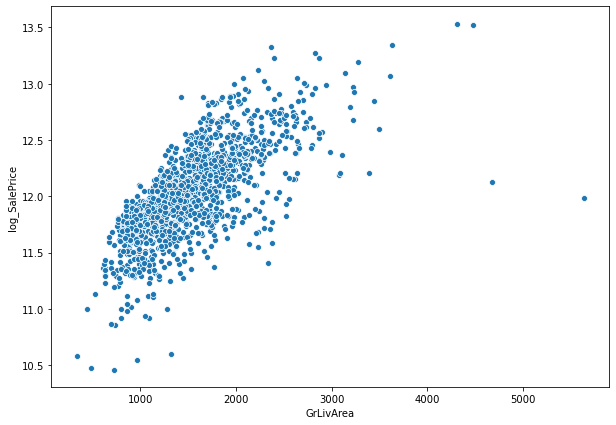

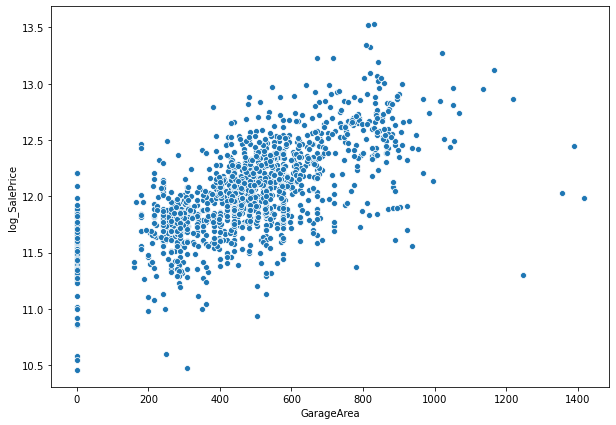

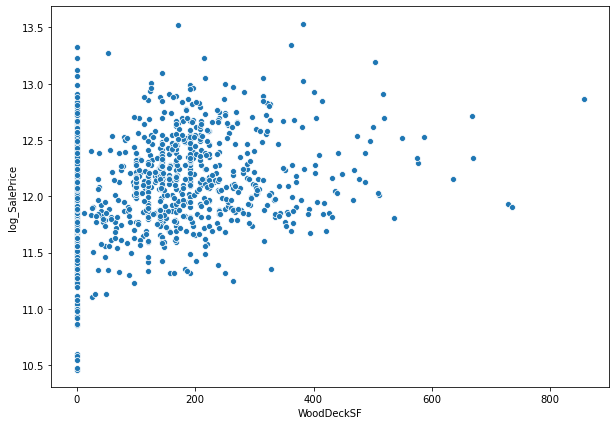

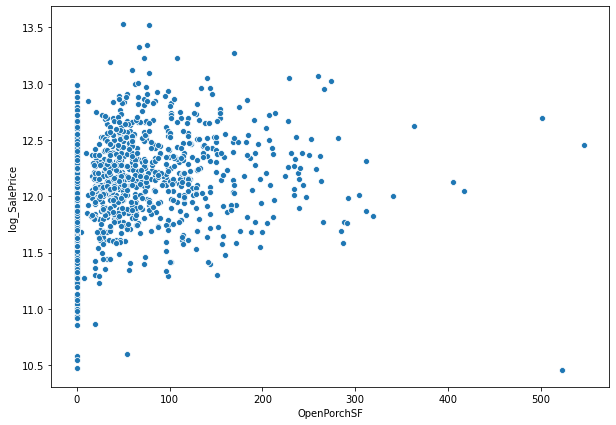

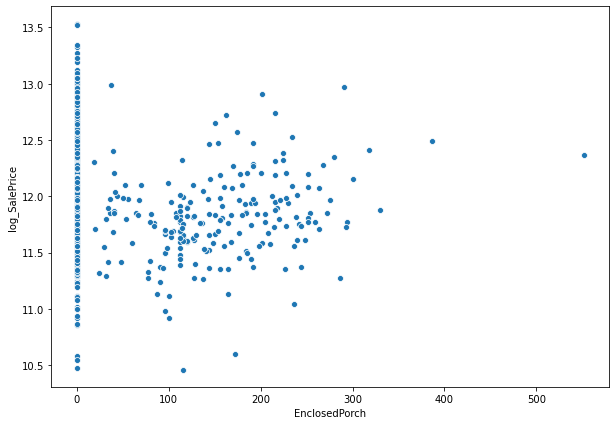

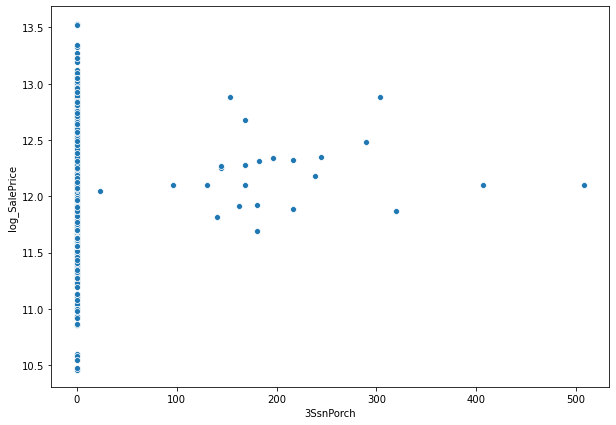

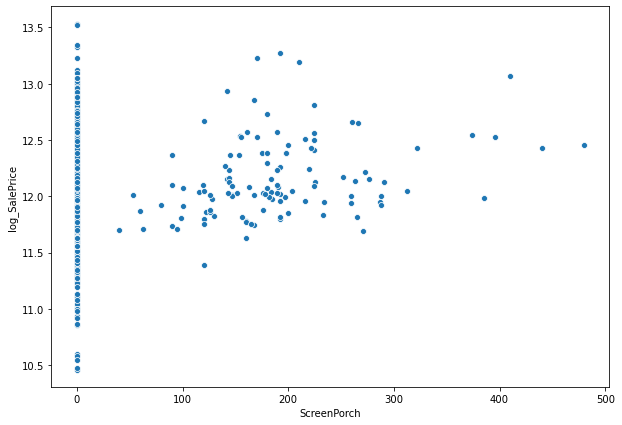

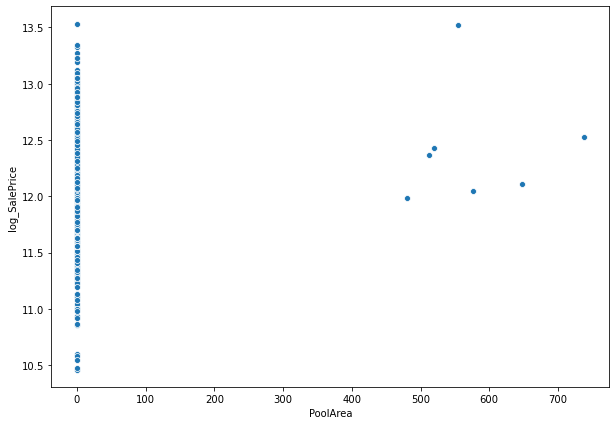

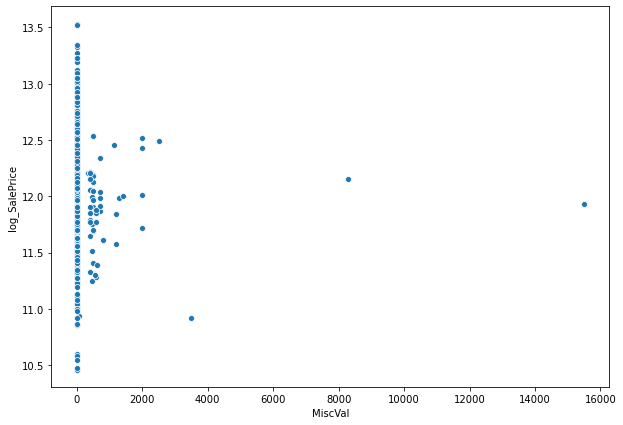

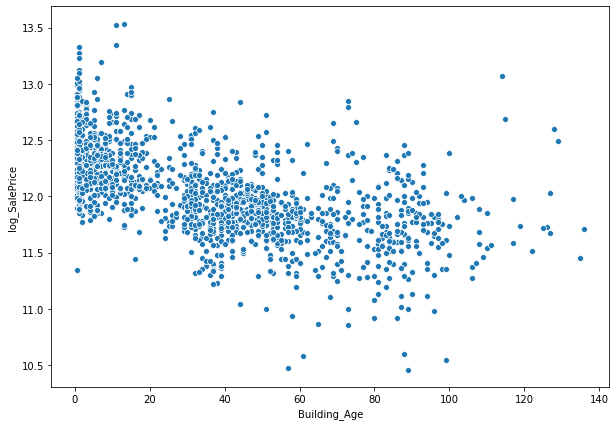

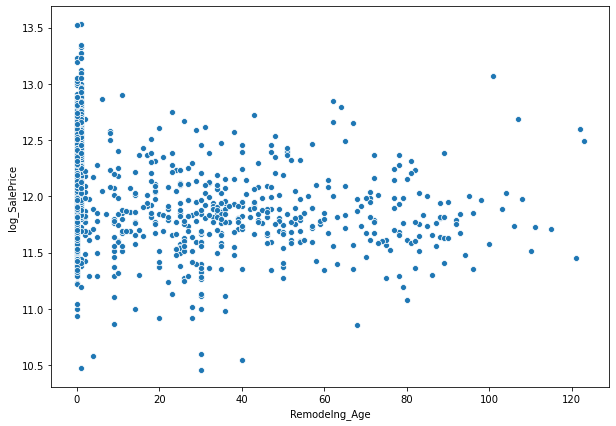

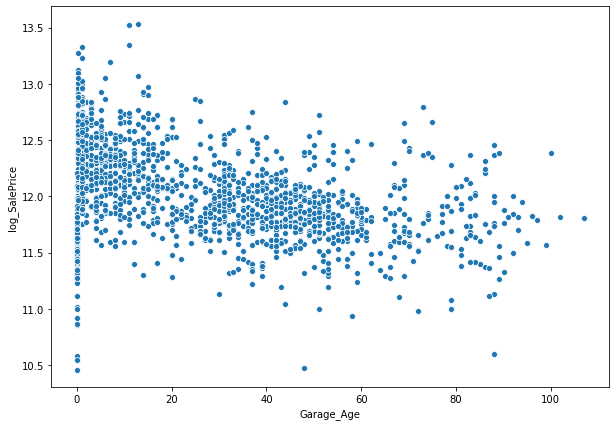

In [35]:
cont_vars.remove('log_SalePrice')
for item in cont_vars:
    plt.figure(figsize = (10,7))
    sns.scatterplot(y = sub_data.log_SalePrice, x = sub_data[item])

- SalePrice has a  linear relation with 1stFlrSF, YearBuilt, 2ndFlrSF, GrLivArea, GarageArea. 
- We can use linear regression model for prediction as there is linear relationship with the predictors and target variable.
- Also we can observe the presence of outliers in the data, these have to be treated before model building. Important variables with outliers in them: 1stFlrSF,GrLivArea, 2ndFlrSF,LotFrontage, LotArea, MasVnrArea, BsmtFinSF1, etc.

#### Dummy variable details
variables in ord_cate_vars are ordered categorical variables. We need to create dummy variables for unordered categorical varaibles in category_vars

In [36]:
ord_cate_vars.extend(['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond'])
a = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond']
for item in a:
    category_vars.remove(item)
print(len(ord_cate_vars)+len(category_vars)+len(cont_vars))
print(sub_data.shape)

69
(1460, 70)


convert ordered categorical variables into numeric. Following are the variables and available categories(with order) for them. 

- Ex, Gd, Ta, fa, Po - ExterQual, ExterCond, HeatingQC, KitchenQual
- Ex, Gd, Ta, fa, Po, NA - BsmtQual, BsmtCond, FireplaceQu, GarageQual, GarageCond
- Gd,Av,Mn,No,NA - BsmtExposure

In [37]:
sub_data[['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 
         'GarageQual', 'GarageCond']] = sub_data[['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 
                                                  'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond']].replace({'NA':0,'PO':1, 'FA':2,'TA':3,'GD':4,'EX':5})
sub_data['BsmtExposure'] = sub_data.BsmtExposure.replace({'NA':0,'NO':1,'MN':2, 'AV':3,'GD':4})

In [38]:
cate = sub_data.select_dtypes(exclude = 'object')
num_vars = []
num_vars.extend(cont_vars)
num_vars.extend(ord_cate_vars)
#verify whether all columns in the dataset are covered in the cont_vars, ord_cate_vars and category_vars
set(num_vars).symmetric_difference(set(cate))

{'MSSubClass', 'MoSold', 'log_SalePrice'}

In [39]:
#verify whether all columns in the dataset are covered in the cont_vars, ord_cate_vars and category_vars
a= []
a.extend(category_vars)
cate = sub_data.select_dtypes(include = 'object')
set(a).symmetric_difference(set(cate))

{'MSSubClass', 'MoSold'}

MSSubClass and MoSold are present in the category_vars

All necesaray operations that have to be performed before train-test are completed. Let's create train and test dataset

### Train Test Split

In [40]:
train, test = train_test_split(sub_data, train_size = 0.70, test_size = 0.30, random_state = 100)
print('train shape = {0}, test shape{1}'.format(train.shape, test.shape))
print('----------missing avlues in train-----------','\n',train.isnull().sum().sort_values(ascending =False)[:5])
print('----------missing values in test------------','\n',test.isnull().sum().sort_values(ascending =False)[:5])

train shape = (1021, 70), test shape(438, 70)
----------missing avlues in train----------- 
 LotFrontage     177
MasVnrType        4
MasVnrArea        4
BsmtExposure      0
ExterQual         0
dtype: int64
----------missing values in test------------ 
 LotFrontage    82
MasVnrType      4
MasVnrArea      4
Electrical      1
HeatingQC       0
dtype: int64


#### Outlier Treatment: Check and treat outliers in the major independent variables
1stFlrSF, GrLivArea, 2ndFlrSF, LotFrontage, LotArea, MasVnrArea, BsmtFinSF1

count    1021.000000
mean     1168.353575
std       398.008990
min       372.000000
25%       875.000000
50%      1086.000000
75%      1422.000000
90%      1689.000000
95%      1839.000000
max      4692.000000
Name: 1stFlrSF, dtype: float64


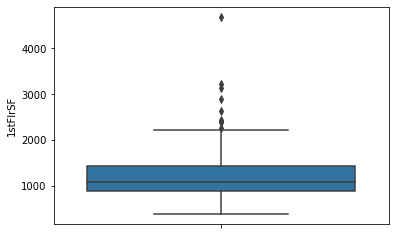

In [41]:
# check outliers in 1stFlrSF
print(train['1stFlrSF'].describe(percentiles = [0.25,0.5,0.75,.9, 0.95]))
sns.boxplot(train['1stFlrSF'], orient='v')

We can see that there is 1 datapoint which is resulting in high skewness. Let's drop this point.

In [42]:
print((train['1stFlrSF'] >4000).sum())
train = train[~(train['1stFlrSF'] > 4000)]
print(train.shape)

1
(1020, 70)


count    1020.000000
mean     1512.981373
std       516.338784
min       438.000000
25%      1134.000000
50%      1466.000000
75%      1768.000000
90%      2142.700000
95%      2466.350000
max      4676.000000
Name: GrLivArea, dtype: float64


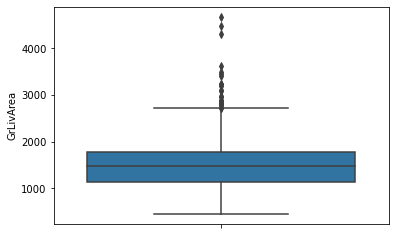

In [43]:
# check outliers in GrLiveArea
print(train['GrLivArea'].describe(percentiles = [0.25,0.5,0.75,.9, 0.95]))
sns.boxplot(train['GrLivArea'], orient='v')

In [44]:
# drop values above 4000
print((train['GrLivArea'] >4000).sum())
train = train[~(train['GrLivArea'] > 4000)]
train['GrLivArea'].describe(percentiles = [0.25,0.5,0.75,.9, 0.95])

3


count    1017.000000
mean     1504.201573
std       491.013508
min       438.000000
25%      1134.000000
50%      1464.000000
75%      1768.000000
90%      2133.600000
95%      2450.400000
max      3627.000000
Name: GrLivArea, dtype: float64

count    1017.000000
mean      337.703048
std       428.037462
min         0.000000
25%         0.000000
50%         0.000000
75%       720.000000
90%       933.600000
95%      1128.200000
max      1818.000000
Name: 2ndFlrSF, dtype: float64


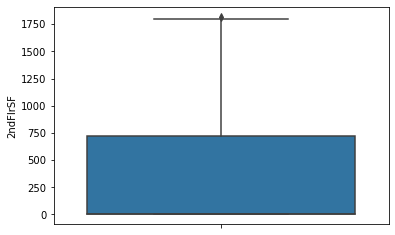

In [45]:
# check outliers in 2ndFlrSF
print(train['2ndFlrSF'].describe(percentiles = [0.25,0.5,0.75,.9, 0.95]))
sns.boxplot(train['2ndFlrSF'], orient='v')

There is large number of cases which are having a value 0 for 2ndFlrSF. This could be possible due to single story builiding. So let's keep it as it is.

count    840.000000
mean      69.148810
std       22.500865
min       21.000000
25%       59.000000
50%       68.000000
75%       80.000000
90%       95.000000
95%      107.000000
max      182.000000
Name: LotFrontage, dtype: float64


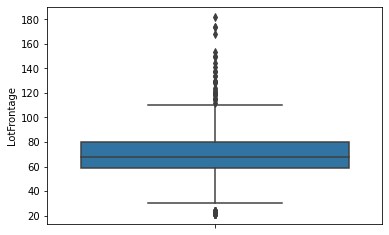

In [46]:
# check outliers in LotFrontage
print(train['LotFrontage'].describe(percentiles = [0.25,0.5,0.75,.9, 0.95]))
sns.boxplot(train['LotFrontage'], orient='v')

Since the presence of outlier is not just isolated cases here, let's keep them and use scaling to suppress them. 

count      1017.000000
mean      10388.199607
std       10142.601001
min        1477.000000
25%        7438.000000
50%        9490.000000
75%       11475.000000
90%       14157.000000
95%       17107.200000
max      215245.000000
Name: LotArea, dtype: float64


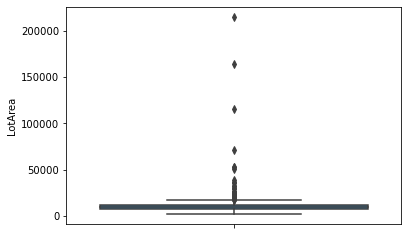

In [47]:
# check outliers in LotArea
print(train.LotArea.describe(percentiles = [0.25,0.5,0.75,.9, 0.95]))
sns.boxplot(train['LotArea'], orient='v')

7
(1010, 70)


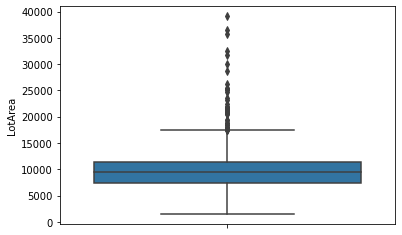

In [48]:
#LotArea is having too many ouliers in it. Let's put an upper limit of 100000 and see
print((train['LotArea'] >50000).sum())
train = train[~(train['LotArea'] > 50000)]
print(train.shape)
sns.boxplot(train.LotArea, orient='v')

count    1006.000000
mean      102.987078
std       182.763912
min         0.000000
25%         0.000000
50%         0.000000
75%       157.500000
90%       335.500000
95%       455.000000
max      1600.000000
Name: MasVnrArea, dtype: float64


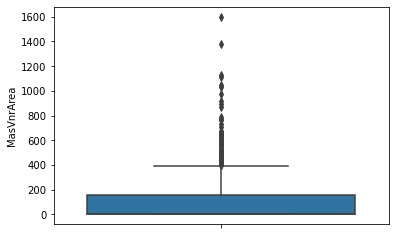

In [49]:
# check outliers in MasVnrArea
print(train.MasVnrArea.describe(percentiles = [0.25,0.5,0.75,.9, 0.95]))
sns.boxplot(train['MasVnrArea'], orient='v')

2
(1008, 70)


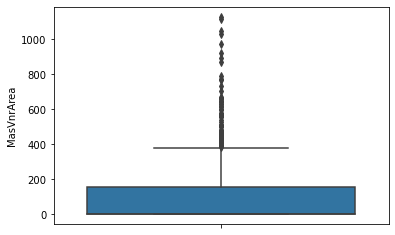

In [50]:
# remove datapoints which are greater than 1200 in value
print((train['MasVnrArea'] >1200).sum())
train = train[~(train['MasVnrArea'] > 1200)]
print(train.shape)
sns.boxplot(train.MasVnrArea, orient='v')

count    1008.000000
mean      431.966270
std       423.731613
min         0.000000
25%         0.000000
50%       383.500000
75%       700.000000
90%      1036.000000
95%      1243.200000
max      1880.000000
Name: BsmtFinSF1, dtype: float64
(1008, 70)


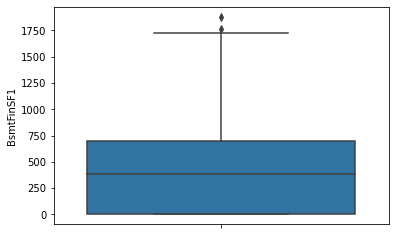

In [51]:
# check outliers in BsmtFinSF1
print(train.BsmtFinSF1.describe(percentiles = [0.25,0.5,0.75,.9, 0.95]))
sns.boxplot(train['BsmtFinSF1'], orient='v')
print(train.shape)

There is a slight presence of outliers in BsmtFinSF1. But let's use scaling to reduce it's impact.

#### Missing value imputation

In [52]:
print(train.isnull().sum().sort_values(ascending = False)[:5])

LotFrontage     173
MasVnrType        4
MasVnrArea        4
BsmtExposure      0
ExterQual         0
dtype: int64


There are 3 variables which are have missing values in train set: LotFrontage, MasVnrType & MasVnrArea. The best value with which the missing values have to be imputed should be extracted from train set.

Dropping missing values of LotFrontage is not a good idea as the amount of available data is already less. Let's check the disrtibution of it

In [53]:
# check the distribution to identify the best value to impute with
train.LotFrontage.describe()

count    835.000000
mean      69.007186
std       22.327784
min       21.000000
25%       58.500000
50%       68.000000
75%       80.000000
max      182.000000
Name: LotFrontage, dtype: float64

Median is a good value to impute with in LotFrontage variable.

In [54]:
train.LotFrontage.fillna(train.LotFrontage.median(), inplace =True)
train.LotFrontage.describe()

count    1008.000000
mean       68.834325
std        20.323094
min        21.000000
25%        60.000000
50%        68.000000
75%        78.000000
max       182.000000
Name: LotFrontage, dtype: float64

Distribution of LotFrontage has not changed immensely due to this imputation. Hence we can proceed with this.

In [55]:
# identify suitable parameter for imputation in MasVnrType
print(train.MasVnrType.value_counts(dropna = False))

NONE       597
BRKFACE    306
STONE       91
BRKCMN      10
NaN          4
Name: MasVnrType, dtype: int64


In [56]:
#impute with mode for MasVnrType
train.MasVnrType.fillna(train.MasVnrType.mode()[0],inplace = True)
train.MasVnrArea.describe()

count    1004.000000
mean      100.226096
std       172.065343
min         0.000000
25%         0.000000
50%         0.000000
75%       154.500000
max      1129.000000
Name: MasVnrArea, dtype: float64

In [57]:
#Let's impute MasVnrArea with median
train.MasVnrArea.fillna(train.MasVnrArea.median(),inplace = True)
train.isnull().sum().sum()

0

##### Missing value imputation for test data

In [58]:
test.isnull().sum().sort_values(ascending = False)[:5]

LotFrontage    82
MasVnrType      4
MasVnrArea      4
Electrical      1
HeatingQC       0
dtype: int64

In [59]:
# 1. LotFrontage
test.LotFrontage.fillna(train.LotFrontage.median(), inplace = True)
# 2. MasVnrType
test.MasVnrType.fillna(train.MasVnrType.mode()[0],inplace = True)
# 3.MasVnrArea
test.MasVnrArea.fillna(train.MasVnrArea.median(),inplace = True)
# 4. Electrical
train.Electrical.value_counts()

C:\Users\veena\anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


SBRKR    920
FUSEA     64
FUSEF     21
FUSEP      3
Name: Electrical, dtype: int64

In [60]:
test.Electrical.fillna(train.Electrical.mode()[0],inplace = True)
test.isnull().sum().sum()

0

### Dummy Variable Creation

Create dummy variables for nominal variables 

In [61]:
# Use OneHotEncoder for dummy variable creation on train data
enc = OneHotEncoder(handle_unknown='ignore').fit(train[category_vars])
train_dummy = pd.DataFrame(enc.transform(train[category_vars]).toarray(), columns=enc.get_feature_names(category_vars))
train_dummy.reset_index(inplace = True, drop =True)
train.reset_index(inplace = True, drop =True)
train_dummy = pd.concat([train,train_dummy], axis =1)
train_dummy.drop(category_vars, axis = 1, inplace = True)
train_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1008 entries, 0 to 1007
Columns: 250 entries, LotFrontage to MoSold_12
dtypes: float64(214), int64(36)
memory usage: 1.9 MB


we can see that all columns have a numeric data type. Now this can be used by the model.

Perform the same data processing in test data as well.

In [62]:
# Use the already fit onehotencoder to tansform test data
test_dummy = pd.DataFrame(enc.transform(test[category_vars]).toarray(), columns=enc.get_feature_names(category_vars))
test_dummy.reset_index(inplace = True, drop =True)
test.reset_index(inplace = True, drop =True)
test_dummy = pd.concat([test,test_dummy], axis =1)
test_dummy.drop(category_vars, axis = 1, inplace = True)
test_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438 entries, 0 to 437
Columns: 250 entries, LotFrontage to MoSold_12
dtypes: float64(214), int64(36)
memory usage: 855.6 KB


In [63]:
# Separate target and predictor variables for test and train
y_train = train_dummy['log_SalePrice']
y_test = test_dummy['log_SalePrice']
X_train = train_dummy.drop('log_SalePrice', axis = 1)
X_test = test_dummy.drop('log_SalePrice', axis = 1)

### Linear Regression - OLS

In [64]:
# Scale the numeric variables to bring down all of them into single scale and to reduce the impact of outliers.
scaler = MinMaxScaler()
X_train_OLS = X_train.copy()
X_test_OLS = X_test.copy()
X_train_OLS[num_vars] = scaler.fit_transform(X_train_OLS[num_vars])
X_test_OLS[num_vars] = scaler.transform(X_test_OLS[num_vars])
lin_m1 = LinearRegression()
lin_m1.fit(X_train_OLS,y_train)
y_pred_train = lin_m1.predict(X_train_OLS)
print('R2 train:', r2_score(y_train,y_pred_train))
y_pred_test = lin_m1.predict(X_test_OLS)
print('R2 test:', r2_score(y_test,y_pred_test))

R2 train: 0.9557898423502428
R2 test: -1.624830498248877e+20


Build a linear regression model with 100 variables. use RFE for feature selection

In [65]:
lin_m1 = LinearRegression()
rfe = RFE(lin_m1, 100)
rfe.fit(X_train_OLS,y_train)
features = X_train_OLS.columns[rfe.support_]
features

C:\Users\veena\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_features_to_select=100 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Index(['1stFlrSF', 'MSZoning_C (ALL)', 'MSZoning_FV', 'MSZoning_RH',
       'MSZoning_RL', 'MSZoning_RM', 'LotShape_IR1', 'LotShape_IR2',
       'LotShape_IR3', 'LotShape_REG', 'LandContour_BNK', 'LandContour_HLS',
       'LandContour_LOW', 'LandContour_LVL', 'LandSlope_GTL', 'LandSlope_MOD',
       'LandSlope_SEV', 'BldgType_1FAM', 'BldgType_2FMCON', 'BldgType_DUPLEX',
       'BldgType_TWNHSE', 'BldgType_TWNHSI', 'HouseStyle_1.5FIN',
       'HouseStyle_1.5UNF', 'HouseStyle_1STORY', 'HouseStyle_2.5FIN',
       'HouseStyle_2.5UNF', 'HouseStyle_2STORY', 'HouseStyle_SFOYER',
       'HouseStyle_SLVL', 'RoofStyle_FLAT', 'RoofStyle_GABLE',
       'RoofStyle_GAMBREL', 'RoofStyle_HIP', 'RoofStyle_MANSARD',
       'RoofStyle_SHED', 'Exterior1st_ASPHSHN', 'Exterior1st_CBLOCK',
       'Exterior2nd_ASPHSHN', 'Exterior2nd_CBLOCK', 'BsmtFinType2_ALQ',
       'BsmtFinType2_BLQ', 'BsmtFinType2_GLQ', 'BsmtFinType2_LWQ',
       'BsmtFinType2_NA', 'BsmtFinType2_REC', 'BsmtFinType2_UNF',
       'CentralAi

In [66]:
# fit a model on selected features and observe the performance
X_train_OLS = X_train_OLS[features]
X_test_OLS = X_test_OLS[features]
lin_m2 = LinearRegression()
lin_m2.fit(X_train_OLS,y_train)
y_pred_train = lin_m2.predict(X_train_OLS)
print('R2 train:', r2_score(y_train,y_pred_train))
y_pred_test = lin_m2.predict(X_test_OLS)
print('R2 test:', r2_score(y_test,y_pred_test))

R2 train: 0.8357069029644008
R2 test: -6.183022460611258e+20


We can observe overfitting.

### Advanced Regression

In [67]:
# scale the variables to get teh dataset with mean 0 and standadrd deviation 1 for teh variables
cols_X = train_dummy.columns
train_R = pd.DataFrame(scale(train_dummy), columns = cols_X)
test_R = pd.DataFrame(scale(test_dummy), columns = cols_X)

In [68]:
y_train = train_R['log_SalePrice']
y_test = test_R['log_SalePrice']
X_train = train_R.drop('log_SalePrice', axis = 1)
X_test = test_R.drop('log_SalePrice', axis = 1)

### Ridge Regression

Use Gridserach to identify the optimum value of alpha

In [69]:
alp = {'alpha':[0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}
ridge = Ridge()
model_CV = GridSearchCV(ridge,param_grid=alp,scoring='r2', cv= 5, return_train_score=True)
model_CV.fit(X_train,y_train)
print(model_CV.best_params_)
print(model_CV.best_score_)

{'alpha': 100}
0.9143205611959067


- Optimum value of alpha for Ridge is 100 and the best R squared value is 0.914
- Build Ridge with alpha as 100 and check its performance

In [70]:
ridge = Ridge(alpha = 100)
ridge.fit(X_train,y_train)
y_train_R_pred = ridge.predict(X_train)
y_test_R_pred = ridge.predict(X_test)
metrics = pd.DataFrame(columns = ['Regre_type','R2_train','R2_test','MSE_train','MSE_test'])
metrics.loc[0] = ['Ridge',r2_score(y_train,y_train_R_pred),r2_score(y_test,y_test_R_pred),mean_squared_error(y_train,y_train_R_pred), mean_squared_error(y_test,y_test_R_pred)]
metrics

Regre_type  R2_train   R2_test  MSE_train  MSE_test
0      Ridge   0.95189  0.897858    0.04811  0.102142

Ridge is mainly performed when we want to keep all variables in the model. So feature selection is not doen Ridge. Coefficients of less important variables will be close to 0.
- Test and train r2 score indicates a well performing model

Validate LR assumptions

Text(0.5, 0, 'residuals')

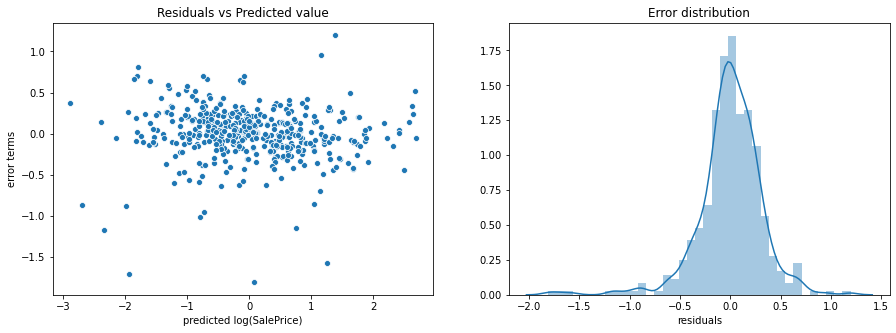

In [71]:
# calculate residuals and check for normalcy, homoscedasticity, etc.
res = y_test - y_test_R_pred
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.scatterplot(y_test_R_pred,res)
plt.title('Residuals vs Predicted value')
plt.xlabel('predicted log(SalePrice)')
plt.ylabel('error terms')
plt.subplot(1,2,2)
sns.distplot(res)
plt.title('Error distribution')
plt.xlabel('residuals')

In [72]:
# extract coefficients of independent variabels given by Ridge
coefs = pd.DataFrame()
coefs['features'] = X_train.columns
coefs['coefs_ridge'] = ridge.coef_

In [73]:
# check the most important variables
coefs.sort_values(by = 'coefs_ridge', ascending = False)[:10]

features  coefs_ridge
17    GrLivArea     0.149187
14     1stFlrSF     0.127716
2   OverallQual     0.122869
10   BsmtFinSF1     0.101846
3   OverallCond     0.083084
27   GarageArea     0.071112
1       LotArea     0.060752
15     2ndFlrSF     0.059364
12    BsmtUnfSF     0.052932
20     FullBath     0.044214

In [74]:
# check the most important variables
coefs.sort_values(by = 'coefs_ridge', ascending = False)[240:]

features  coefs_ridge
130    Exterior1st_WD SDNG    -0.029105
216  SaleCondition_ABNORML    -0.029205
182         Functional_SEV    -0.029298
119    Exterior1st_BRKCOMM    -0.030853
71    Neighborhood_EDWARDS    -0.032582
74    Neighborhood_MEADOWV    -0.035829
223          MSSubClass_30    -0.041512
40        MSZoning_C (ALL)    -0.077208
37            Building_Age    -0.080332

Most significant variables in predicting the price of a house - 
- +ve influence: GrLivArea, 1stFlrSF, OverallQual, BsmtFinSF1, OverallCond
- -ve influence: Building_Age

## Lasso Regression

Use Gridserach to identify the optimum value of alpha

In [75]:
lasso = Lasso()
lasso_cv = GridSearchCV(lasso, cv = 5, param_grid = alp, return_train_score=True,scoring='r2')
lasso_cv.fit(X_train,y_train)
lasso_cv.best_params_

C:\Users\veena\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08606158813816123, tolerance: 0.0812442869719054
  model = cd_fast.enet_coordinate_descent(
C:\Users\veena\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1036780048121706, tolerance: 0.07944180031198499
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.01}

Best value of alpha is 0.01. Build a Lasso model with this and observe the performance

In [76]:
lasso = Lasso(alpha = 0.01)
lasso.fit(X_train,y_train)
y_train_L_pred = lasso.predict(X_train)
y_test_L_pred = lasso.predict(X_test)
metrics.loc[1] = ['Lasso',r2_score(y_train,y_train_L_pred),r2_score(y_test,y_test_L_pred),mean_squared_error(y_train,y_train_L_pred),mean_squared_error(y_test,y_test_L_pred)]
print(metrics)
coefs['coefs_lasso'] = lasso.coef_
lasso_imp_featu = coefs[coefs.coefs_lasso != 0]
lasso_imp_featu.sort_values(by='coefs_lasso',ascending =False)

  Regre_type  R2_train   R2_test  MSE_train  MSE_test
0      Ridge  0.951890  0.897858   0.048110  0.102142
1      Lasso  0.943303  0.904842   0.056697  0.095158


features  coefs_ridge  coefs_lasso
17               GrLivArea     0.149187     0.314273
2              OverallQual     0.122869     0.186794
10              BsmtFinSF1     0.101846     0.102853
3              OverallCond     0.083084     0.098132
27              GarageArea     0.071112     0.077819
..                     ...          ...          ...
216  SaleCondition_ABNORML    -0.029205    -0.031452
44             MSZoning_RM    -0.015760    -0.033757
223          MSSubClass_30    -0.041512    -0.034343
40        MSZoning_C (ALL)    -0.077208    -0.073445
37            Building_Age    -0.080332    -0.138213

[95 rows x 3 columns]

Check for linear regression assumptions

Text(0.5, 1.0, 'Error distribution')

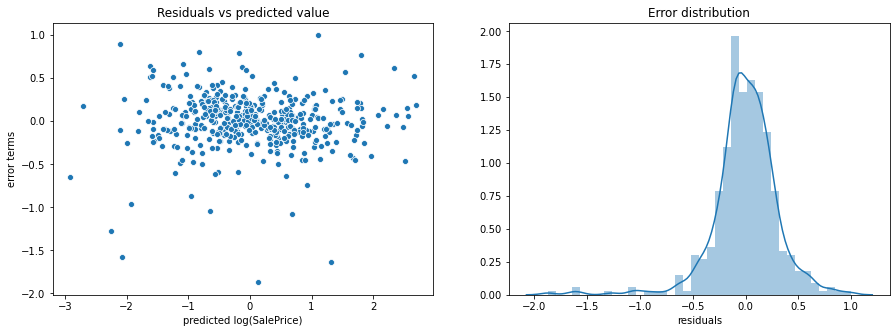

In [77]:
res = y_test - y_test_L_pred
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title('Residuals vs predicted value')
sns.scatterplot(y_test_L_pred,res)
plt.xlabel('predicted log(SalePrice)')
plt.ylabel('error terms')
plt.subplot(1,2,2)
sns.distplot(res)
plt.xlabel('residuals')
plt.title('Error distribution')

Most significant variables in predicting the price of a house - 
- +ve influence: GrLivArea, OverallQual, BsmtFinSF1, OverallCond, GarageArea
- -ve influence: Building_Age

In [78]:
metrics

Regre_type  R2_train   R2_test  MSE_train  MSE_test
0      Ridge  0.951890  0.897858   0.048110  0.102142
1      Lasso  0.943303  0.904842   0.056697  0.095158

-By observing the R2 values and MSE for train and test data, we can consider Lasso with alpha 0.01 as the best suited model for this dataset.
- Most significant variables: GrLivArea, OverallQual, Building_Age, BsmtFinSF1, OverallCond, GarageArea 
- Impact or coefficient for these varaibles are:
    - GrLivArea: 0.314273
    - OverallQual: 0.186794
    - Building_Age: -0.138213
    - BsmtFinSF1: 0.102853
    - OverallCond: 0.098132
    - GarageArea: 0.077819
These coefficients represents the relation with logarithmic value of Saleprice. 

Text(0, 0.5, 'Predicted SalePrice')

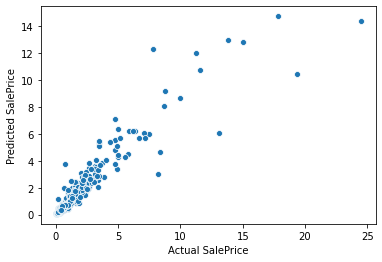

In [79]:
#Actual SalePrice
SalePrice_test = np.exp(y_test)
SalePrice_pred = np.exp(y_test_L_pred)
sns.scatterplot(SalePrice_test, SalePrice_pred)
plt.xlabel('Actual SalePrice')
plt.ylabel('Predicted SalePrice')